## 1. Importar Librerias

In [ ]:
#pip install rapidfuzz

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from matplotlib import cm
import random
import glob
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
import joblib
import re
import unicodedata

from rapidfuzz import fuzz, process #limpieza datos
from itertools import combinations
from collections import Counter
from scipy.sparse import csr_matrix, coo_matrix

import unidecode
def remove_accents(a):
    return unidecode.unidecode(a)

##  2. Carga y Procesamiento de Datos


### 2.1 Cargar licitaciones

In [ ]:
# Definir la ruta donde se encuentran los archivos de licitaciones
path = 'C:/Users/SCL_SERVIDOR/Desktop/Capstone Project'  # Cambia esto si tus archivos están en otra carpeta

# Definir el patrón de archivos
pattern = 'licitaciones_*.csv'

# Usar glob para obtener la lista de archivos que coinciden con el patrón
all_files = glob.glob(os.path.join(path, pattern))

# Verificar los archivos encontrados
print(f"Archivos encontrados: {all_files}")

In [ ]:
# Lista para almacenar cada DataFrame anual
list_of_dfs = []

for file in all_files:
    # Extraer el año del nombre del archivo
    basename = os.path.basename(file)  # Ejemplo: 'licitaciones_2014.csv'
    year = basename.split('_')[1].split('.')[0]
    
    # Leer el archivo CSV
    df = pd.read_csv(file, sep=',', encoding='latin-1', decimal='.')
    
    # Añadir una columna para el año
    df['Año'] = int(year)
    
    # Agregar el DataFrame a la lista
    list_of_dfs.append(df)

# Concatenar todos los DataFrames en uno solo
lic_all_years = pd.concat(list_of_dfs, ignore_index=True)

# Verificar la concatenación
print(f"Total de registros combinados: {lic_all_years.shape[0]}")

### 2.2 Fusión con sectores

In [ ]:
ruta='C:/Users/chaco/OneDrive/Escritorio/Magister Data Science/Capstone Proyect/Cod'
archivos_en_ruta=os.listdir(ruta)
print(archivos_en_ruta)

In [ ]:
archivo=os.path.join(ruta,'sectores.csv')
try:
    sectores=pd.read_csv(archivo,sep=";")
    print("Archivo cargado correctamente.")
except FileNotFoundError:
    print(f"El archivo '{archivo}'no se encuentra")
except Exception as e:
    print(f"Error al cargar el archivo: {e}")

In [ ]:
# Asegurarse de que las columnas clave están en el mismo formato
lic_all_years['NombreOrganismo'] = lic_all_years['NombreOrganismo'].astype(str).str.strip()
sectores['Nombre de la institución'] = sectores['Nombre de la institución'].astype(str).str.strip()

# Fusionar con sector 
lic_all_years = pd.merge(
    lic_all_years,
    sectores[['Nombre de la institución','Sector']],
    how='left',
    left_on="NombreOrganismo",
    right_on='Nombre de la institución'
)

lic_all_years.drop(columns=["Nombre de la institución"],inplace=True)

### 2.3 Fusión con Rubros


In [ ]:
archivo=os.path.join(ruta,'rubros_onu.xlsx')
try:
    rubros_onu=pd.read_excel(archivo)
    print("Archivo cargado correctamente.")
except FileNotFoundError:
    print(f"El archivo '{archivo}'no se encuentra")
except Exception as e:
    print(f"Error al cargar el archivo: {e}")

In [ ]:
# Asegurarse de que las columnas clave están en el mismo formato
lic_all_years['CodigoProductoONU'] = lic_all_years['CodigoProductoONU'].astype(str).str.strip()
rubros_onu['CodigoProductoONU'] = rubros_onu['CodigoProductoONU'].astype(str).str.strip()

# Fusionar con rubros ONU
lic_all_years = pd.merge(
    lic_all_years,
    rubros_onu[['CodigoProductoONU','NombreProducto','RubroN2']],
    how='left',
    on='CodigoProductoONU'
)

### 2.4 Guardar y Cargar Data Unificada (2014-2023)

In [ ]:
#ruta = 'C:/Users/SCL_SERVIDOR/Desktop/Capstone Project/lic_combinadas_2014_2018.csv'
#lic_all_years.to_csv(ruta, index=False, encoding='utf-8-sig')

In [44]:
lic_all_years = pd.read_csv('lic_combinadas_2014_2023.csv')

C:\Users\Realitec UDD\AppData\Local\Temp\ipykernel_24588\2980668233.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  lic_all_years = pd.read_csv('lic_combinadas_2014_2023.csv')


## 3. Limpieza de Datos

In [45]:
lic_all_years["Oferta seleccionada"].value_counts()

Oferta seleccionada
No Seleccionada    23949475
Seleccionada        5890193
No sleccionada      2383606
Perdedora            619087
Name: count, dtype: int64

In [46]:
# Optimizar tipos de datos
lic_all_years['MontoLineaAdjudica'] = lic_all_years['MontoLineaAdjudica'].astype(np.float32)
mapeo_oferta = {
    'Seleccionada': 'Seleccionada',
    'No Seleccionada': 'No Seleccionada',
    'No sleccionada': 'No Seleccionada',
    'Perdedora': 'No Seleccionada'
}
lic_all_years['Oferta seleccionada'] = lic_all_years['Oferta seleccionada'].replace(mapeo_oferta)
# Mapear a valores numéricos para cálculos
lic_all_years['Oferta seleccionada'] = lic_all_years['Oferta seleccionada'].map({'Seleccionada': 1, 'No Seleccionada': 0}).astype(np.int8)

In [47]:
# Limpiar el dataframe
lic_all_years_clean = lic_all_years[
    ~lic_all_years["NombreProveedor"].isin(["-", ".", "---------", "- - -", " ", "--", "0", "000000", "1"]) &  # Restricción de nombres no válidos
    lic_all_years["NombreProveedor"].notna() &  # Evitar valores NaN
    (
        (lic_all_years["Oferta seleccionada"] != 1) |  # Cuando no está adjudicado, no aplicar filtro de monto
        (
            (lic_all_years["MontoLineaAdjudica"] >= 1) &  # Aplicar filtro de monto solo cuando está adjudicado
            (lic_all_years["MontoLineaAdjudica"] <= 10**12)
        )
    )
]

In [48]:
lic_all_years_clean["Oferta seleccionada"].value_counts()

Oferta seleccionada
0    26945392
1     5852659
Name: count, dtype: int64

In [49]:
# Función para limpiar y estandarizar nombres
def limpiar_nombre(nombre):
    if pd.isna(nombre):  # Verifica si el valor es NaN
        return np.nan
    # Eliminar tildes
    nombre = unicodedata.normalize('NFD', nombre).encode('ascii', 'ignore').decode('utf-8')
    # Convertir a minúsculas
    nombre = nombre.lower()
    # Eliminar caracteres no alfabéticos y no numéricos (excepto espacios)
    nombre = re.sub(r'[^a-zA-Z0-9\s]', '', nombre)
    # Eliminar palabras como "spa", "ltda", etc.
    nombre = re.sub(r'\b(spa|ltda|sac|sa|sas|corp|inc|company|co|com|limit|limitada|limita|anónima)\b', '', nombre)
    # Eliminar múltiples espacios y dejar solo uno
    nombre = re.sub(r'\s+', ' ', nombre).strip()
    return nombre


# Crear una nueva columna para los nombres originales
lic_all_years_clean['NombreProveedorOriginal'] = lic_all_years_clean['NombreProveedor']

# Limpiar y crear la columna de nombres limpios
lic_all_years_clean['NombreProveedorLimpio'] = lic_all_years_clean['NombreProveedor'].apply(limpiar_nombre)

# Comparar nombres originales vs limpios
comparacion_nombres = lic_all_years_clean[['NombreProveedorOriginal', 'NombreProveedorLimpio']]

C:\Users\Realitec UDD\AppData\Local\Temp\ipykernel_24588\4098513312.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_all_years_clean['NombreProveedorOriginal'] = lic_all_years_clean['NombreProveedor']
C:\Users\Realitec UDD\AppData\Local\Temp\ipykernel_24588\4098513312.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_all_years_clean['NombreProveedorLimpio'] = lic_all_years_clean['NombreProveedor'].apply(limpiar_nombre)


In [50]:
lic_all_years_clean["Oferta seleccionada"].value_counts()

Oferta seleccionada
0    26945392
1     5852659
Name: count, dtype: int64

In [51]:
# Eliminar filas donde 'NombreProveedorLimpio' es vacío ("") después de la limpieza
lic_all_years_clean = lic_all_years_clean[lic_all_years_clean['NombreProveedorLimpio'] != ""]

In [52]:
lic_all_years_clean["Oferta seleccionada"].value_counts()

Oferta seleccionada
0    26944772
1     5852588
Name: count, dtype: int64

### 3.1 Filtrar datos del 2014-2018

In [54]:
# Filtrar la data por los años 2014 a 2018
lic_all_years_clean_2014_2018 = lic_all_years_clean[(lic_all_years_clean['Año'] >= 2014) & (lic_all_years_clean['Año'] <= 2018)]
lic_all_years_clean_2019_2023 = lic_all_years_clean[(lic_all_years_clean['Año'] >= 2019) & (lic_all_years_clean['Año'] <= 2023)]

## Análisis Descriptivo

### Evolución anual de la cantidad de licitaciones

In [65]:
lic_all_years_clean.columns

Index(['Codigo', 'Tipo de Adquisicion', 'NombreOrganismo', 'FechaPublicacion',
       'CodigoProductoONU', 'NombreProveedor', 'Moneda de la Oferta',
       'MontoUnitarioOferta', 'CantidadAdjudicada', 'MontoLineaAdjudica',
       'Oferta seleccionada', 'Año', 'Sector', 'NombreProducto', 'RubroN2',
       'NombreProveedorOriginal', 'NombreProveedorLimpio'],
      dtype='object')

In [86]:
lic_all_years_clean["Año"].value_counts()

Año
2014    7944382
2015    5162693
2016    4143290
2017    3469286
2018    2974004
2019    2768589
2022    2116695
2020    1880982
2021    1648646
2023     688793
Name: count, dtype: int64

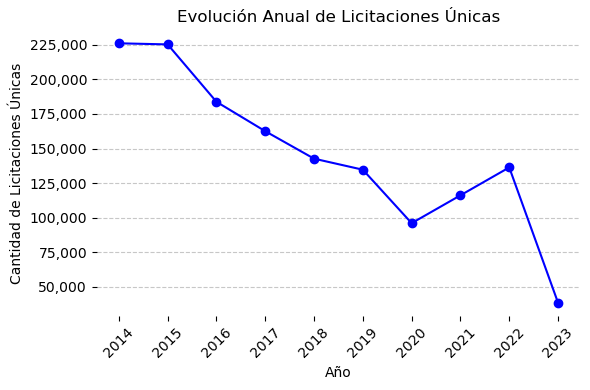

In [92]:
# Contar licitaciones únicas por año usando la columna 'Codigo'
licitaciones_unicas_por_año = lic_all_years_clean.groupby('Año')['Codigo'].nunique()

# Crear el gráfico
plt.figure(figsize=(6, 4))
plt.plot(licitaciones_unicas_por_año.index, licitaciones_unicas_por_año.values, marker='o', linestyle='-', color='blue')

# Etiquetas y título
plt.title('Evolución Anual de Licitaciones Únicas', fontsize=12)
plt.xlabel('Año', fontsize=10)
plt.ylabel('Cantidad de Licitaciones Únicas', fontsize=10)

# Mostrar valores completos en el eje y (evitar exponenciales)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Ajustar etiquetas del eje x
plt.xticks(licitaciones_unicas_por_año.index, rotation=45)

# Líneas de rejilla horizontales
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Eliminar bordes del gráfico
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Guardar y mostrar el gráfico
plt.tight_layout()
plt.savefig('evolucion_licitaciones_unicas_anual_sin_bordes.png', bbox_inches='tight', dpi=300)
plt.show()

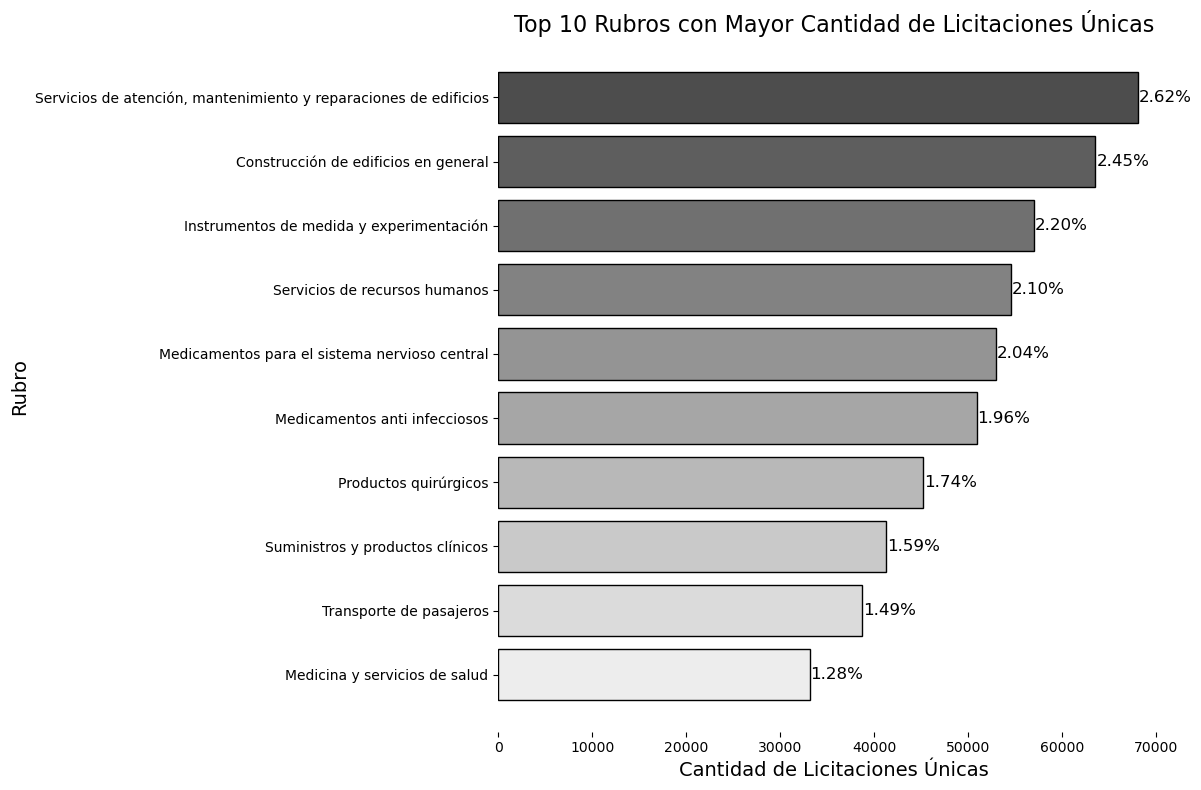

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Contar licitaciones únicas por rubro
licitaciones_por_rubro = lic_all_years_clean.groupby('RubroN2')['Codigo'].nunique()

# Calcular el total de licitaciones únicas en todo el dataset
total_licitaciones = licitaciones_por_rubro.sum()

# Obtener el top 10 rubros con mayor cantidad de licitaciones únicas
top_10_rubros = licitaciones_por_rubro.sort_values(ascending=False).head(10)

# Calcular el porcentaje de participación de cada rubro respecto al total
top_10_rubros_percent = (top_10_rubros / total_licitaciones) * 100

# Crear un gradiente de colores en escala de grises (oscuro para mayor valor, claro para menor)
num_rubros = len(top_10_rubros)
colors = [str(0.3 + (i / num_rubros) * 0.7) for i in range(num_rubros)]  # De 0.3 (gris oscuro) a 1 (gris claro)

# Crear el gráfico
plt.figure(figsize=(12, 8))
bars = plt.barh(top_10_rubros.index, top_10_rubros.values, color=colors, edgecolor='black')

# Etiquetas y título
plt.title('Top 10 Rubros con Mayor Cantidad de Licitaciones Únicas', fontsize=16)
plt.xlabel('Cantidad de Licitaciones Únicas', fontsize=14)
plt.ylabel('Rubro', fontsize=14)

# Invertir el eje y para que los rubros con más licitaciones estén arriba
plt.gca().invert_yaxis()

# Añadir etiquetas con el % de participación respecto al total
for bar, percentage in zip(bars, top_10_rubros_percent):
    plt.text(
        bar.get_width() + 100,  # Posición ligeramente a la derecha del final de la barra
        bar.get_y() + bar.get_height() / 2,  # Centrado verticalmente
        f"{percentage:.2f}%",  # Formato de porcentaje con 2 decimales
        va='center',
        fontsize=12
    )

# Eliminar bordes del gráfico
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Ajustar diseño y guardar el gráfico
plt.tight_layout()
plt.savefig('top_10_licitaciones_unicas_por_rubro_escala_gris_porcentaje_total.png', bbox_inches='tight', dpi=300)
plt.show()

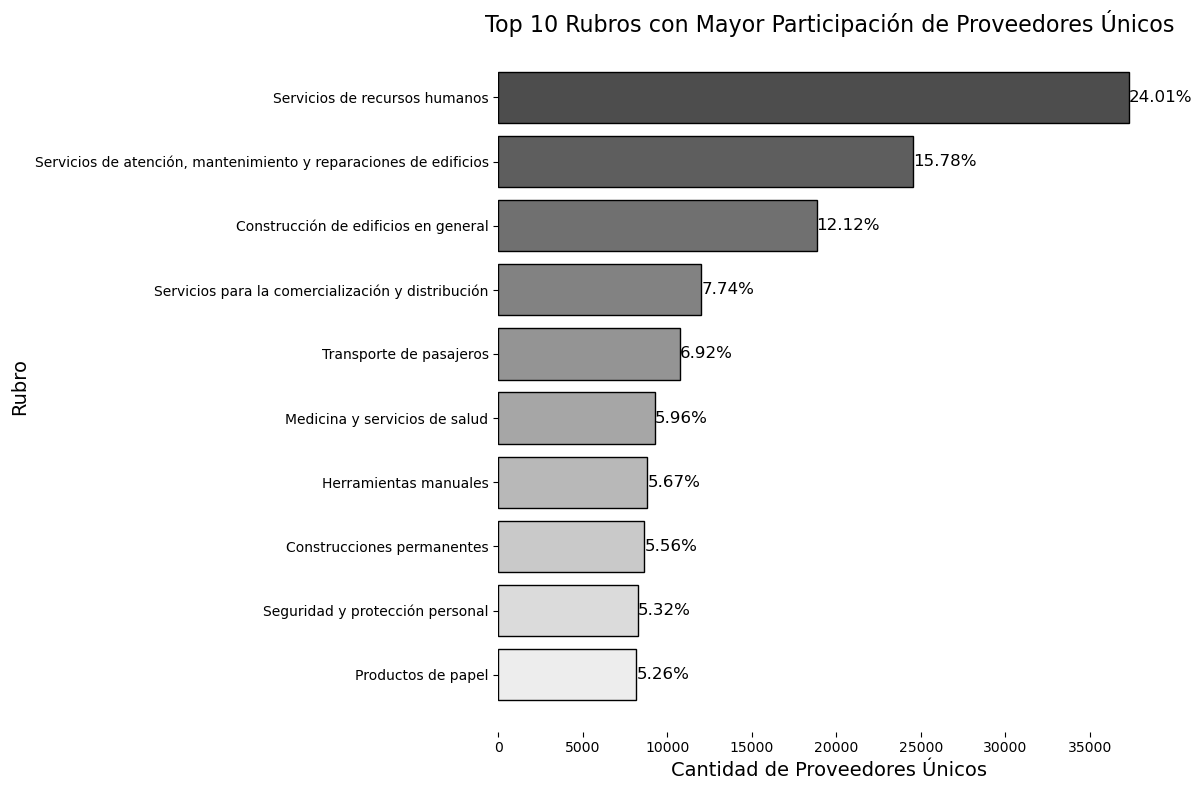

In [118]:
import pandas as pd
import matplotlib.pyplot as plt

# Contar proveedores únicos por rubro
proveedores_por_rubro = lic_all_years_clean.groupby('RubroN2')['NombreProveedorLimpio'].nunique()

# Calcular el total de proveedores únicos en todo el dataset sin duplicados
total_proveedores = lic_all_years_clean['NombreProveedorLimpio'].nunique()

# Obtener el top 10 rubros con mayor participación de proveedores
top_10_proveedores_rubro = proveedores_por_rubro.sort_values(ascending=False).head(10)

# Calcular el porcentaje de participación respecto al total único
top_10_proveedores_percent = (top_10_proveedores_rubro / total_proveedores) * 100

# Crear un gradiente de colores en escala de grises
num_rubros = len(top_10_proveedores_rubro)
colors = [str(0.3 + (i / num_rubros) * 0.7) for i in range(num_rubros)]  # Gris oscuro a claro

# Crear el gráfico
plt.figure(figsize=(12, 8))
bars = plt.barh(top_10_proveedores_rubro.index, top_10_proveedores_rubro.values, color=colors, edgecolor='black')

# Etiquetas y título
plt.title('Top 10 Rubros con Mayor Participación de Proveedores Únicos', fontsize=16)
plt.xlabel('Cantidad de Proveedores Únicos', fontsize=14)
plt.ylabel('Rubro', fontsize=14)

# Invertir el eje y para que los rubros con más proveedores estén arriba
plt.gca().invert_yaxis()

# Añadir etiquetas con el % de participación
for bar, percentage in zip(bars, top_10_proveedores_percent):
    plt.text(
        bar.get_width() + 5,  # Posición ligeramente a la derecha del final de la barra
        bar.get_y() + bar.get_height() / 2,  # Centrado verticalmente
        f"{percentage:.2f}%",  # Formato de porcentaje con 2 decimales
        va='center',
        fontsize=12
    )

# Eliminar bordes del gráfico
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Ajustar diseño y guardar el gráfico
plt.tight_layout()
plt.savefig('top_10_proveedores_por_rubro_corregido_porcentaje.png', bbox_inches='tight', dpi=300)
plt.show()

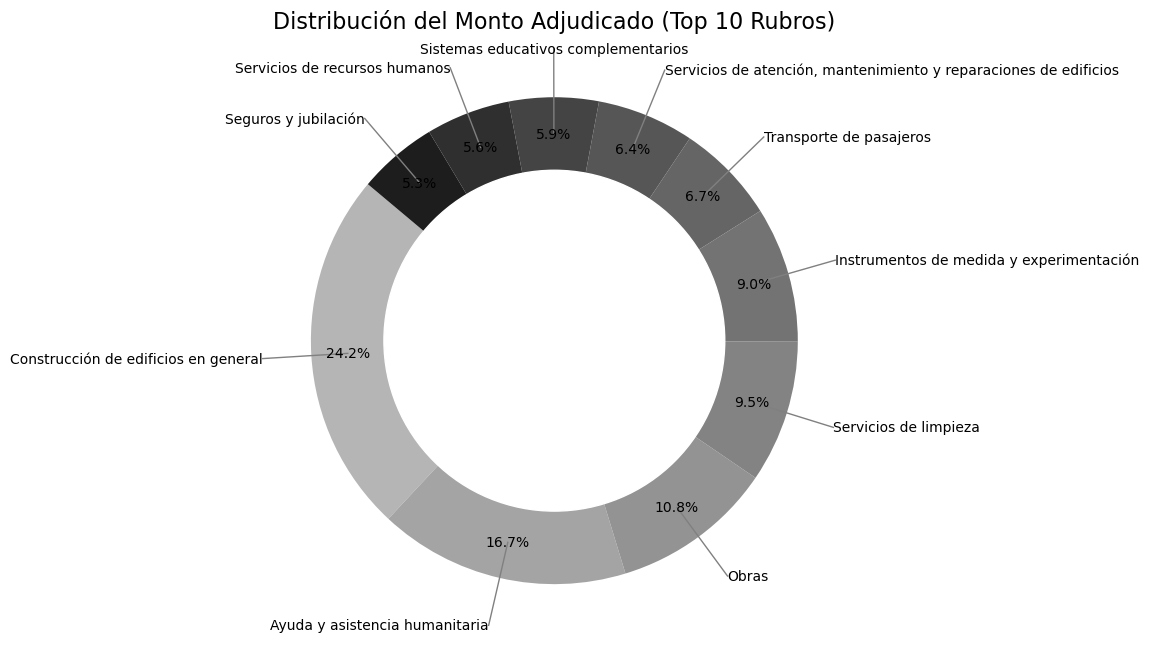

In [160]:
import matplotlib.pyplot as plt
import numpy as np

# Crear el gráfico donut con líneas de conexión
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    top_10_montos_rubro,
    labels=None,  # No incluir etiquetas directamente
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Greys(np.linspace(0.4, 0.9, len(top_10_montos_rubro))),
    pctdistance=0.85  # Ajustar posición de los porcentajes
)

# Agregar el círculo central para crear el efecto de donut
plt.gca().add_artist(plt.Circle((0, 0), 0.7, color='white'))

# Agregar etiquetas con líneas de conexión
for i, (wedge, label) in enumerate(zip(wedges, top_10_montos_rubro.index)):
    angle = (wedge.theta2 + wedge.theta1) / 2  # Calcular ángulo central del wedge
    x = np.cos(np.deg2rad(angle))  # Coordenada x en el círculo
    y = np.sin(np.deg2rad(angle))  # Coordenada y en el círculo

    # Posición del texto fuera del donut
    x_text = 1.2 * x
    y_text = 1.2 * y

    # Líneas de conexión entre el wedge y el texto
    plt.plot([0.85 * x, x_text], [0.85 * y, y_text], color='gray', lw=1)

    # Agregar la etiqueta del rubro
    plt.text(
        x_text,
        y_text,
        label,
        ha='center' if abs(x) < 0.1 else ('left' if x > 0 else 'right'),
        va='center',
        fontsize=10
    )

# Configuración del título
plt.title('Distribución del Monto Adjudicado (Top 10 Rubros)', fontsize=16)
plt.tight_layout()

# Guardar y mostrar el gráfico
plt.savefig('top_10_monto_adjudicado_donut_chart_with_leader_lines.png', dpi=300)
plt.show()

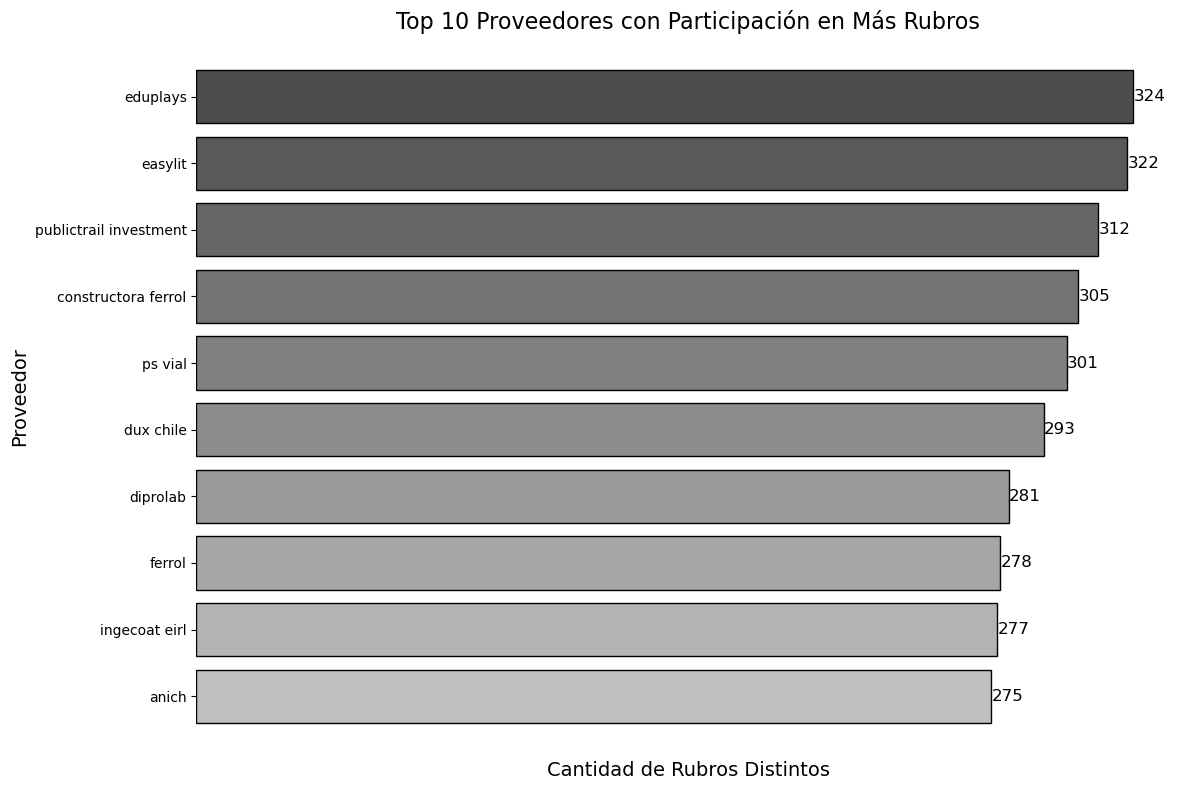

In [206]:
plt.figure(figsize=(12, 8))
num_proveedores = len(top_proveedores_rubros)
colors = [str(0.3 + (i / num_proveedores) * 0.5) for i in range(num_proveedores)]
bars = plt.barh(top_proveedores_rubros.index, top_proveedores_rubros.values, color=colors, edgecolor='black')

# Etiquetas y título
plt.title('Top 10 Proveedores con Participación en Más Rubros', fontsize=16)
plt.xlabel('Cantidad de Rubros Distintos', fontsize=14)
plt.ylabel('Proveedor', fontsize=14)

# Invertir el eje Y
plt.gca().invert_yaxis()

# Añadir etiquetas de valores
for bar in bars:
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2, f'{int(bar.get_width())}', va='center', fontsize=12)

# Eliminar bordes del marco
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Eliminar las marcas del eje X
plt.gca().tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Guardar y mostrar
plt.tight_layout()
plt.savefig('top_proveedores_por_rubro_gris_sin_marco_eje_x_eliminado.png', dpi=300, bbox_inches='tight')
plt.show()

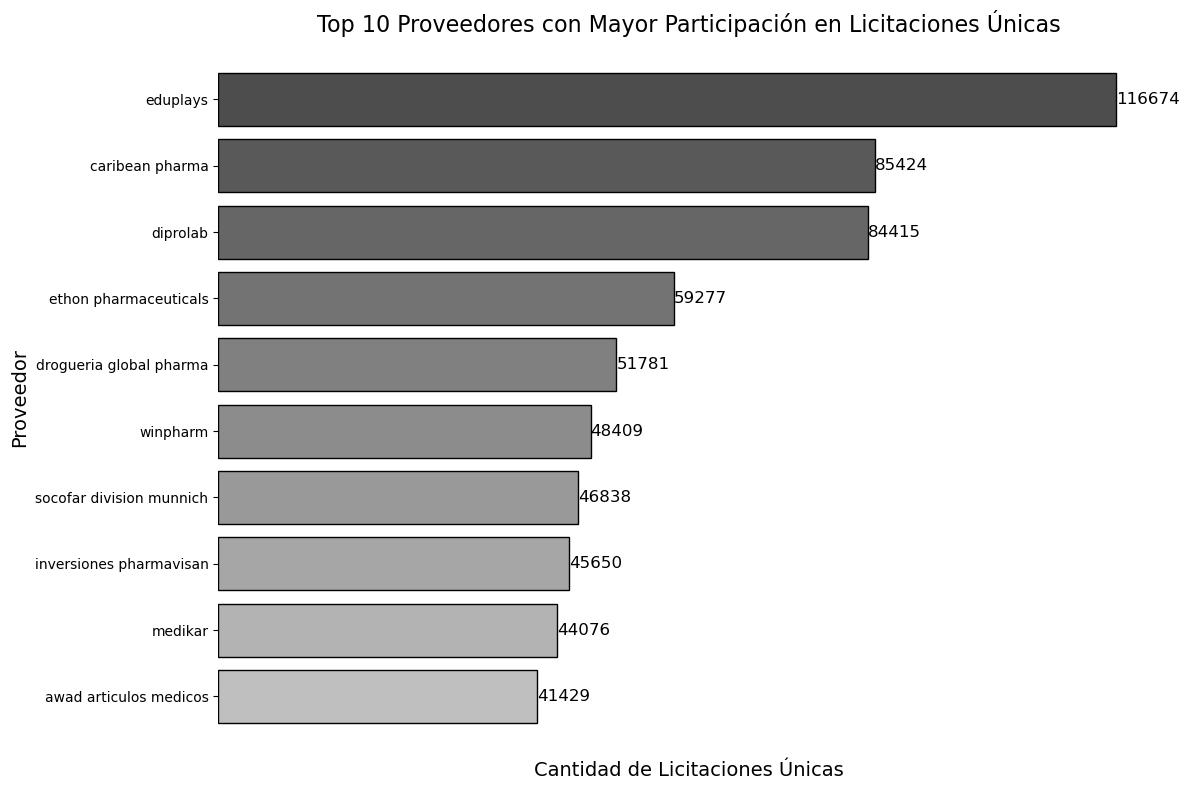

In [212]:
import matplotlib.pyplot as plt

# Agrupar por proveedor y contar las licitaciones únicas en las que participaron
participaciones_proveedores = lic_all_years_clean.groupby('NombreProveedorLimpio')['Codigo'].nunique()

# Ordenar por cantidad de licitaciones y seleccionar el top 10
top_proveedores_participaciones = participaciones_proveedores.sort_values(ascending=False).head(10)

# Crear el gráfico
plt.figure(figsize=(12, 8))
num_proveedores = len(top_proveedores_participaciones)

# Escala de grises para las barras
colors = [str(0.3 + (i / num_proveedores) * 0.5) for i in range(num_proveedores)]

# Graficar las barras horizontales
bars = plt.barh(top_proveedores_participaciones.index, top_proveedores_participaciones.values, color=colors, edgecolor='black')

# Etiquetas y título
plt.title('Top 10 Proveedores con Mayor Participación en Licitaciones Únicas', fontsize=16)
plt.xlabel('Cantidad de Licitaciones Únicas', fontsize=14)
plt.ylabel('Proveedor', fontsize=14)

# Invertir el eje Y para mostrar al proveedor con mayor participación en la parte superior
plt.gca().invert_yaxis()

# Añadir etiquetas con los valores al final de cada barra
for bar in bars:
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2, f'{int(bar.get_width())}', va='center', fontsize=12)

# Eliminar bordes del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Eliminar marcas del eje X
plt.gca().tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Guardar y mostrar
plt.tight_layout()
plt.savefig('top_proveedores_participaciones_unicas_gris.png', dpi=300, bbox_inches='tight')
plt.show()

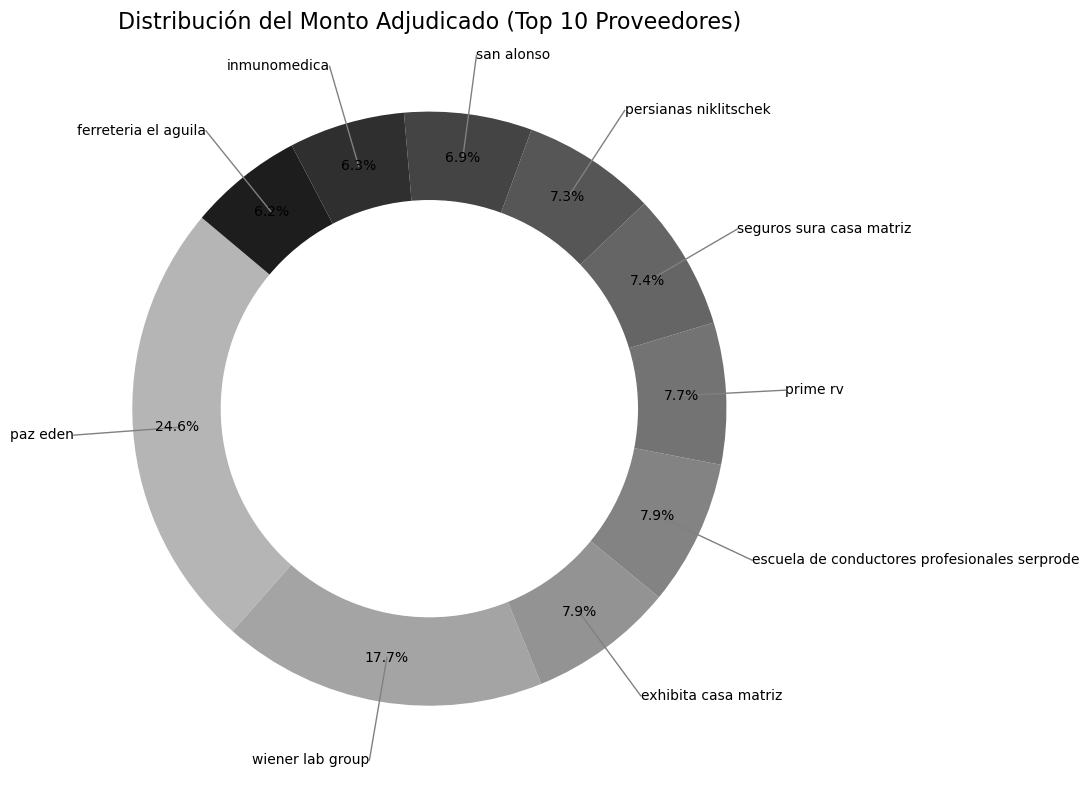

In [216]:
import matplotlib.pyplot as plt
import numpy as np

# Agrupar por proveedor y sumar los montos adjudicados
montos_por_proveedor = lic_all_years_clean[lic_all_years_clean['Oferta seleccionada'] == 1].groupby('NombreProveedorLimpio')['MontoLineaAdjudica'].sum()

# Obtener el top 10 proveedores por monto adjudicado
top_10_montos_proveedor = montos_por_proveedor.sort_values(ascending=False).head(10)

# Crear el gráfico donut con líneas de conexión
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    top_10_montos_proveedor,
    labels=None,  # No incluir etiquetas directamente
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Greys(np.linspace(0.4, 0.9, len(top_10_montos_proveedor))),
    pctdistance=0.85  # Ajustar posición de los porcentajes
)

# Agregar el círculo central para crear el efecto de donut
plt.gca().add_artist(plt.Circle((0, 0), 0.7, color='white'))

# Agregar etiquetas con líneas de conexión
for i, (wedge, label) in enumerate(zip(wedges, top_10_montos_proveedor.index)):
    angle = (wedge.theta2 + wedge.theta1) / 2  # Calcular ángulo central del wedge
    x = np.cos(np.deg2rad(angle))  # Coordenada x en el círculo
    y = np.sin(np.deg2rad(angle))  # Coordenada y en el círculo

    # Posición del texto fuera del donut
    x_text = 1.2 * x
    y_text = 1.2 * y

    # Líneas de conexión entre el wedge y el texto
    plt.plot([0.85 * x, x_text], [0.85 * y, y_text], color='gray', lw=1)

    # Agregar la etiqueta del proveedor
    plt.text(
        x_text,
        y_text,
        label,
        ha='center' if abs(x) < 0.1 else ('left' if x > 0 else 'right'),
        va='center',
        fontsize=10
    )

# Configuración del título
plt.title('Distribución del Monto Adjudicado (Top 10 Proveedores)', fontsize=16)
plt.tight_layout()

# Guardar y mostrar el gráfico
plt.savefig('top_10_monto_adjudicado_donut_chart_proveedores.png', dpi=300)
plt.show()


In [ ]:
top_10_montos_proveedor

## 4. Cálculo VCR

In [ ]:
licitacion_col = 'Codigo'
proveedor_col = 'NombreProveedorLimpio'
rubro_col = 'RubroN2'
producto_col = 'CodigoProductoONU'

# Eliminar duplicados basados en licitación, proveedor, rubro y producto
#lic_all_years_unique = lic_all_years_clean.drop_duplicates(subset=[licitacion_col, proveedor_col, rubro_col, producto_col])
lic_all_years_unique_2014_2018 = lic_all_years_clean_2014_2018

# Paso 1: Calcular el número total de participaciones en todos los rubros y proveedores
participaciones_totales = len(lic_all_years_unique_2014_2018)

# Paso 2: Calcular las participaciones únicas de cada proveedor en cada rubro
participaciones_proveedor_rubro = lic_all_years_unique_2014_2018.groupby([proveedor_col, rubro_col]).size()

# Paso 3: Calcular las participaciones totales por proveedor
participaciones_totales_proveedor = lic_all_years_unique_2014_2018[proveedor_col].value_counts()

# Paso 4: Calcular las participaciones totales por rubro
participaciones_totales_rubro = lic_all_years_unique_2014_2018[rubro_col].value_counts()

# Combinar los cálculos en un único DataFrame
vcr_df = participaciones_proveedor_rubro.reset_index(name='participaciones_proveedor_rubro')
vcr_df['participaciones_totales_proveedor'] = vcr_df[proveedor_col].map(participaciones_totales_proveedor)
vcr_df['participaciones_totales_rubro'] = vcr_df[rubro_col].map(participaciones_totales_rubro)

# Calcular el VCR utilizando la fórmula vectorizada
vcr_df['VCR'] = (vcr_df['participaciones_proveedor_rubro'] / vcr_df['participaciones_totales_proveedor']) / \
                (vcr_df['participaciones_totales_rubro'] / participaciones_totales)

# Filtrar proveedores con VCR >= 1 para indicar ventaja comparativa
vcr_df['ventaja_comparativa'] = vcr_df['VCR']>=1

In [ ]:
eduplays=vcr_df[vcr_df["NombreProveedorLimpio"]=="eduplays"]
eduplays_true=eduplays[eduplays["ventaja_comparativa"]==True]

In [ ]:
eduplays_true.head()

## 5. Calculo de Matriz Especialización

In [ ]:
# Paso 1: Filtrar los proveedores con ventaja comparativa
especializacion_df = vcr_df[vcr_df['ventaja_comparativa']][[proveedor_col, rubro_col]]

# Paso 2: Crear índices para proveedores y rubros
proveedores = especializacion_df[proveedor_col].unique()
rubros = especializacion_df[rubro_col].unique()

proveedor_idx = {proveedor: idx for idx, proveedor in enumerate(proveedores)}
rubro_idx = {rubro: idx for idx, rubro in enumerate(rubros)}

# Mapear los nombres a índices
especializacion_df['proveedor_idx'] = especializacion_df[proveedor_col].map(proveedor_idx)
especializacion_df['rubro_idx'] = especializacion_df[rubro_col].map(rubro_idx)

# Verificar que no hay valores NaN en los índices
assert not especializacion_df['proveedor_idx'].isnull().any(), "Hay proveedores sin índice."
assert not especializacion_df['rubro_idx'].isnull().any(), "Hay rubros sin índice."

In [ ]:
# Asegurarse de que los índices son enteros
especializacion_df['proveedor_idx'] = especializacion_df['proveedor_idx'].astype(int)
especializacion_df['rubro_idx'] = especializacion_df['rubro_idx'].astype(int)

# Paso 3: Construir la matriz de especialización dispersa
data = np.ones(len(especializacion_df), dtype=np.int32)  # Cambiado a np.int32
rows = especializacion_df['rubro_idx'].values
cols = especializacion_df['proveedor_idx'].values

matriz_especializacion_sparse = csr_matrix((data, (rows, cols)), shape=(len(rubros), len(proveedores)))

# Verificar si hay valores negativos en matriz_especializacion_sparse
if (matriz_especializacion_sparse.data < 0).any():
    print("Advertencia: Se encontraron valores negativos en matriz_especializacion_sparse")

# Paso 4: Calcular el producto matricial disperso
producto_sparse = matriz_especializacion_sparse @ matriz_especializacion_sparse.T

# Verificar si hay valores negativos en producto_sparse
if (producto_sparse.data < 0).any():
    print("Advertencia: Se encontraron valores negativos en producto_sparse")

# Paso 5: Calcular la suma de proveedores por rubro
suma_por_rubro = np.array(matriz_especializacion_sparse.sum(axis=1)).flatten()

## 6. Cálculo de Proximdiad


In [ ]:
# Paso 6: Calcular la matriz de proximidad
producto_coo = producto_sparse.tocoo()

max_sumas = np.maximum(suma_por_rubro[producto_coo.row], suma_por_rubro[producto_coo.col])

# Evitar divisiones por cero
max_sumas[max_sumas == 0] = np.finfo(float).eps

# Calcular la proximidad
proximidad_data = producto_coo.data / max_sumas

# Verificar si hay valores negativos en proximidad_data
if (proximidad_data < 0).any():
    print("Advertencia: Se encontraron valores negativos en proximidad_data")

# Crear la matriz dispersa de proximidad
proximidad_sparse = coo_matrix((proximidad_data, (producto_coo.row, producto_coo.col)), shape=producto_sparse.shape)

# Opcional: Convertir a DataFrame si es manejable en memoria
idx_to_rubro = {idx: rubro for rubro, idx in rubro_idx.items()}
rubro_labels = [idx_to_rubro[idx] for idx in range(len(rubros))]

proximidad_df = pd.DataFrame.sparse.from_spmatrix(proximidad_sparse, index=rubro_labels, columns=rubro_labels)

In [ ]:
proximidad_df.head()

In [ ]:
proximidad_df.columns

In [ ]:
print(f"Valor mínimo de proximidad: {proximidad_data.min()}")
print(f"Valor máximo de proximidad: {proximidad_data.max()}")

## 7. Red de Rubros 

In [ ]:
# Crear un grafo desde la matriz de proximidad
G = nx.from_pandas_adjacency(proximidad_df)

In [ ]:
nx.write_gexf(G,"GrafoProximidadRubros.gexf")

In [ ]:
# Mostrar información básica del grafo
print(f"Grafo creado con {G.number_of_nodes()} nodos y {G.number_of_edges()} aristas.")

# Opcional: Guardar el grafo en un archivo para visualización (formato GraphML o GEXF)
nx.write_gexf(G, "grafo_proximidad.gexf")

In [ ]:
# Crear un diccionario para almacenar las métricas
metrics = {}

# Métricas básicas
metrics['weighted_degree'] = dict(G.degree(weight='weight'))  # Grado ponderado
metrics['betweenness_centrality'] = nx.betweenness_centrality(G, weight='weight')  # Centralidad de intermediación
metrics['closeness_centrality'] = nx.closeness_centrality(G)  # Centralidad de cercanía
metrics['pagerank'] = nx.pagerank(G, weight='weight')  # PageRank
metrics['clustering_coefficient'] = nx.clustering(G, weight='weight')  # Coeficiente de agrupamiento

# Crear un DataFrame con todas las métricas
metrics_df = pd.DataFrame(metrics)

In [ ]:
# Resetear el índice para incluir los nodos como una columna
metrics_df.reset_index(inplace=True)

# Renombrar la columna del índice como "Rubro"
metrics_df.rename(columns={'index': 'Rubro'}, inplace=True)

In [ ]:
# Mostrar las primeras filas del DataFrame
metrics_df.head()

## 8. Cálculo de Density Relatedness 

In [ ]:
# Preparar matrices y diccionarios
matriz_especializacion_csr = matriz_especializacion_sparse.tocsr()
proximidad_csr = proximidad_sparse.tocsr()
todos_los_rubros = set(range(len(rubros)))
idx_to_proveedor = {idx: proveedor for proveedor, idx in proveedor_idx.items()}
idx_to_rubro = {idx: rubro for rubro, idx in rubro_idx.items()}

In [ ]:
# Inicializar listas para resultados
lista_proveedores = []
lista_rubros_potenciales = []
lista_density_relatedness = []

# Obtener la diagonal completa de proximidad_csr una sola vez
diagonal_proximidad = proximidad_csr.diagonal()

# Calcular el portafolio de cada proveedor y la density relatedness
for proveedor_idx_actual in range(matriz_especializacion_csr.shape[1]):
    rubros_con_ventaja = matriz_especializacion_csr[:, proveedor_idx_actual].nonzero()[0]
    rubros_con_ventaja_set = set(rubros_con_ventaja)
    rubros_potenciales = np.array(list(todos_los_rubros - rubros_con_ventaja_set))
    if rubros_potenciales.size == 0:
        continue

    # Obtener las proximidades con el portafolio del proveedor
    proximidades_con_portafolio = proximidad_csr[rubros_potenciales[:, None], rubros_con_ventaja].toarray()

    # Sumar las proximidades con el portafolio para cada rubro potencial
    suma_proximidades_portafolio = proximidades_con_portafolio.sum(axis=1)

    # Obtener las proximidades totales del rubro potencial
    proximidades_totales = proximidad_csr[rubros_potenciales].toarray()

    # Sumar todas las proximidades excepto la del rubro consigo mismo (diagonal)
    diagonales_rubros_potenciales = diagonal_proximidad[rubros_potenciales]
    suma_proximidades_totales = proximidades_totales.sum(axis=1) - diagonales_rubros_potenciales

    # Evitar divisiones por cero
    suma_proximidades_totales[suma_proximidades_totales == 0] = np.finfo(float).eps

    # Calcular la Density Relatedness
    density = suma_proximidades_portafolio / suma_proximidades_totales

    # Almacenar los resultados
    proveedores_repetidos = [idx_to_proveedor[proveedor_idx_actual]] * len(rubros_potenciales)
    rubros_potenciales_nombres = [idx_to_rubro[idx] for idx in rubros_potenciales]
    lista_proveedores.extend(proveedores_repetidos)
    lista_rubros_potenciales.extend(rubros_potenciales_nombres)
    lista_density_relatedness.extend(density)

In [ ]:
# Crear el DataFrame final
density_df = pd.DataFrame({
    'NombreProveedorLimpio': lista_proveedores,
    'RubroPotencial': lista_rubros_potenciales,
    'DensityRelatedness': lista_density_relatedness
})

In [ ]:
density_df.head()

## 9. Enriquecer Caracteristicas del DataFrame

### 9.1 Caracteristicas Proveedor

In [ ]:
import pandas as pd

# Supongamos que 'lic_all_years_clean' es tu DataFrame original
# Primero, creamos una copia del DataFrame para trabajar con ella
df = lic_all_years_clean_2014_2018.copy()

# Filtrar los montos adjudicados
df['MontoTotalAdjudicado'] = df['MontoLineaAdjudica'].where((df['MontoLineaAdjudica'] >= 1) & (df['MontoLineaAdjudica'] <= 10**12))

# Crear una columna que indique si la oferta fue seleccionada
df['Adjudicada'] = df['Oferta seleccionada'] == 'Seleccionada'

# Total adjudicaciones proveedor (solo las adjudicadas)
df['TotalAdjudicacionesProveedor'] = df.groupby('NombreProveedorLimpio')['Adjudicada'].transform('sum')

# Total participaciones proveedor
df['TotalParticipacionesProveedor'] = df.groupby('NombreProveedorLimpio')['Codigo'].transform('size')

# % Adjudicación proveedor
df['%AdjudicacionProveedor'] = (df['TotalAdjudicacionesProveedor'] / df['TotalParticipacionesProveedor']) * 100

# Total Monto adjudicado proveedor (filtrado)
df['TotalMontoAdjudicadoProveedor'] = df.groupby('NombreProveedorLimpio')['MontoTotalAdjudicado'].transform('sum')

# Total Monto promedio adjudicado proveedor (filtrado)
df['TotalMontoPromedioAdjudicadoProveedor'] = df.groupby('NombreProveedorLimpio')['MontoTotalAdjudicado'].transform('mean')

# Numero de rubros con ventaja
df['NumeroRubrosConVentaja'] = df.groupby('NombreProveedorLimpio')['RubroN2'].transform(lambda x: x.nunique())

# Total monto adjudicado rubro (filtrado)
df['TotalMontoAdjudicadoRubro'] = df.groupby('RubroN2')['MontoTotalAdjudicado'].transform('sum')

# Total monto promedio adjudicado rubro (filtrado)
df['TotalMontoPromedioAdjudicadoRubro'] = df.groupby('RubroN2')['MontoTotalAdjudicado'].transform('mean')

# Numero de proveedores rubro
df['NumeroProveedoresRubro'] = df.groupby('RubroN2')['NombreProveedorLimpio'].transform(lambda x: x.nunique())

In [ ]:
# Eliminar duplicados en df para las claves de unión
df_proveedor = df[['NombreProveedorLimpio', 'TotalAdjudicacionesProveedor', 
                   'TotalParticipacionesProveedor', '%AdjudicacionProveedor', 
                   'TotalMontoAdjudicadoProveedor', 
                   'TotalMontoPromedioAdjudicadoProveedor', 
                   'NumeroRubrosConVentaja']].drop_duplicates()

df_rubro = df[['RubroN2', 'TotalMontoAdjudicadoRubro', 
                'TotalMontoPromedioAdjudicadoRubro', 
                'NumeroProveedoresRubro']].drop_duplicates()

# Realizar el merge para las características del proveedor
density_df = density_df.merge(df_proveedor, left_on='NombreProveedorLimpio', right_on='NombreProveedorLimpio', how='left')

# Realizar el merge para las características del rubro
density_df = density_df.merge(df_rubro, left_on='RubroPotencial', right_on='RubroN2', how='left')

# Eliminar las columnas que ya existen en density_df
columnas_a_eliminar = ['RubroN2']  # Agrega más columnas si es necesario
density_df = density_df.loc[:, ~density_df.columns.isin(columnas_a_eliminar)]

# Mostrar el DataFrame resultante
density_df.head()

### 9.2 Unir con metricas de Red

In [ ]:
density_df.shape

In [ ]:
# Realizar el merge para las características del rubro
density_df = density_df.merge(metrics_df, left_on='RubroPotencial', right_on='Rubro', how='left')

# Eliminar las columnas que ya existen en density_df
columnas_a_eliminar_red = ['Rubro']  # Agrega más columnas si es necesario
density_df = density_df.loc[:, ~density_df.columns.isin(columnas_a_eliminar_red)]

In [ ]:
density_df.columns

## 10. Cargar y preprocesar datos de 2019 al 2023 [Generar Etiqueta]

In [ ]:
lic_all_years_clean_2019_2023["Año"].unique()

In [ ]:
# Paso 1: Calcular el número total de participaciones en 2019-2023
participaciones_totales_2019_2023 = len(lic_all_years_clean_2019_2023)

# Paso 2: Calcular las participaciones únicas de cada proveedor en cada rubro
participaciones_proveedor_rubro_2019_2023 = lic_all_years_clean_2019_2023.groupby([proveedor_col, rubro_col]).size()

# Paso 3: Calcular las participaciones totales por proveedor
participaciones_totales_proveedor_2019_2023 = lic_all_years_clean_2019_2023[proveedor_col].value_counts()

# Paso 4: Calcular las participaciones totales por rubro
participaciones_totales_rubro_2019_2023 = lic_all_years_clean_2019_2023[rubro_col].value_counts()

# Combinar los cálculos en un DataFrame
vcr_df_2019_2023 = participaciones_proveedor_rubro_2019_2023.reset_index(name='participaciones_proveedor_rubro')
vcr_df_2019_2023['participaciones_totales_proveedor'] = vcr_df_2019_2023[proveedor_col].map(participaciones_totales_proveedor_2019_2023)
vcr_df_2019_2023['participaciones_totales_rubro'] = vcr_df_2019_2023[rubro_col].map(participaciones_totales_rubro_2019_2023)

# Calcular el VCR
vcr_df_2019_2023['VCR'] = (vcr_df_2019_2023['participaciones_proveedor_rubro'] / vcr_df_2019_2023['participaciones_totales_proveedor']) / \
                           (vcr_df_2019_2023['participaciones_totales_rubro'] / participaciones_totales_2019_2023)

# Determinar si tiene ventaja comparativa
vcr_df_2019_2023['ventaja_comparativa'] = vcr_df_2019_2023['VCR'] >= 1

In [ ]:
vcr_df_2019_2023["ventaja_comparativa"].value_counts()

In [ ]:
vcr_2019_2023_exito = vcr_df_2019_2023[vcr_df_2019_2023['ventaja_comparativa']][[proveedor_col, rubro_col]].copy()
vcr_2019_2023_exito['Exito'] = 1

In [ ]:
vcr_2019_2023_exito.rename(columns={"RubroN2":"RubroPotencial"},inplace=True)

In [ ]:
vcr_2019_2023_exito.columns

In [ ]:
# Realizar el merge
density_df = density_df.merge(vcr_2019_2023_exito[['NombreProveedorLimpio', 'RubroPotencial','Exito']],
                              left_on=['NombreProveedorLimpio', 'RubroPotencial'],
                              right_on=['NombreProveedorLimpio', 'RubroPotencial'],
                              how='left')

In [ ]:
density_df.columns

In [ ]:
# Reemplazar NaN en 'Exito' por 0 (proveedores que no obtuvieron ventaja comparativa en el rubro potencial)
density_df['Exito'] = density_df['Exito'].fillna(0).astype(int)

In [ ]:
# Verificar la distribución de la etiqueta
print(density_df['Exito'].value_counts())

In [ ]:
density_df.shape

In [ ]:
#pip install pyarrow

In [ ]:
density_df.to_parquet("density_data.parquet", engine="pyarrow", compression="snappy")

In [3]:
# Para leer el archivo Parquet que guardaste anteriormente
density_df = pd.read_parquet("density_data.parquet")
density_df.shape

(38810865, 18)

## 11. Definir las Características (Variables Predictoras) y la Etiqueta

In [ ]:
def reduce_memory_usage(df):
    """Reduce el uso de memoria de un DataFrame."""
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:  # Excluir columnas categóricas
            if str(col_type).startswith('int'):
                df[col] = pd.to_numeric(df[col], downcast='integer')
            elif str(col_type).startswith('float'):
                df[col] = pd.to_numeric(df[col], downcast='float')
    return df

# Reducir el uso de memoria
density_df = reduce_memory_usage(density_df)

# Verificar la reducción de memoria
print(density_df.info())

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, average_precision_score, confusion_matrix)
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

# Variables predictoras y objetivo
X = density_df.drop(['RubroPotencial', 'NombreProveedorLimpio', 'Exito'], axis=1)
y = density_df['Exito']

# Escalar las variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir X_scaled nuevamente a un DataFrame con los nombres originales
X = pd.DataFrame(X_scaled, columns=X.columns)

# Reemplazar valores NaN por 0
X = X.fillna(0)

## 12. Implementar Modelo XGboost con proporción 7 veces mas de clase mayoritaria y evaluar en la distribución real de los datos.

In [ ]:
# Dividir los datos en entrenamiento y prueba
X_train_original, X_test, y_train_original, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Dividir los datos en entrenamiento y prueba
X_train_original, X_test, y_train_original, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, average_precision_score, confusion_matrix, 
                             roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
from sklearn.utils import resample

# Crear un conjunto balanceado (Proporción 7)
data_train = X_train_original.copy()
data_train['Exito'] = y_train_original

# Separar las clases
data_majority = data_train[data_train['Exito'] == 0]
data_minority = data_train[data_train['Exito'] == 1]

# Submuestrear la clase mayoritaria
proportion = 7
data_majority_downsampled = resample(
    data_majority,
    replace=False,  # Sin reemplazo
    n_samples=len(data_minority) * proportion,
    random_state=42
)

# Combinar las clases balanceadas
data_balanced = pd.concat([data_majority_downsampled, data_minority])

# Separar las variables predictoras (X) y la etiqueta (y)
X_train = data_balanced.drop('Exito', axis=1)
y_train = data_balanced['Exito']

# Entrenar el modelo
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Exito', 'Exito'], yticklabels=['No Exito', 'Exito'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC = {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.grid()
plt.show()

# Curva PR
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f"AUC-PR = {auc_pr:.4f}")
plt.title('Curva de Precisión-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

# Obtener la importancia de las variables
importance = model.get_booster().get_score(importance_type='weight')

# Garantizar que todas las variables se incluyan, incluso las que no fueron usadas (importancia 0)
all_features = X_train.columns.tolist()
importance_full = {feature: importance.get(feature, 0) for feature in all_features}

# Convertir a DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance_full.keys()),
    'F_Score': list(importance_full.values())
})
importance_df['Percentage'] = (importance_df['F_Score'] / importance_df['F_Score'].sum()) * 100
importance_df = importance_df.sort_values(by='Percentage', ascending=False)

# Mostrar resultados
def print_results():
    print("\n### Resultados del Modelo ###")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR: {auc_pr:.4f}")

    print("\n### Importancia de Variables (Todas) ###")
    print(importance_df)

# Visualización opcional de todas las variables con colores diferenciados
plt.figure(figsize=(12, 8))

# Asignar colores: 'red' para "density relatedness" y 'skyblue' para las demás
colors = ['red' if feature == 'density relatedness' else 'skyblue' for feature in importance_df['Feature']]

plt.barh(importance_df['Feature'], importance_df['Percentage'], color=colors)
plt.xlabel('Porcentaje de Importancia')
plt.ylabel('Variable')
plt.title('Importancia de Todas las Variables')
plt.gca().invert_yaxis()
plt.show()

# Call to display results
print_results()


In [ ]:
# Asignar colores: rojo para "density relatedness" y gris para las demás
colors = ['red' if feature == 'DensityRelatedness' else 'lightgray' for feature in importance_df['Feature']]

# Gráfico
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Percentage'], color=colors, edgecolor='none')

# Configuración del gráfico
plt.xlabel('Porcentaje de Importancia', fontsize=14)
plt.ylabel('Variable', fontsize=14)
plt.title('Importancia de Variables (Destacando density relatedness)', fontsize=16)
plt.gca().invert_yaxis()  # Invertir el eje y para que las variables con mayor importancia estén arriba
plt.show()

### 12.1 Análisis de correlación

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Variables predictoras completas
features = [
    'TotalMontoAdjudicadoProveedor', 'DensityRelatedness',
    'TotalMontoPromedioAdjudicadoProveedor', 'NumeroRubrosConVentaja',
    'TotalParticipacionesProveedor', '%AdjudicacionProveedor',
    'NumeroProveedoresRubro', 'TotalAdjudicacionesProveedor',
    'TotalMontoAdjudicadoRubro', 'TotalMontoPromedioAdjudicadoRubro',
    'weighted_degree', 'clustering_coefficient','betweenness_centrality', 
    'pagerank', 'closeness_centrality']


# Matriz de correlación
correlation_matrix = X_train_original[features].corr()

# Visualizar matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación de Variables Predictoras")
plt.show()

### 12.2 Analisis Multicolinealidad

Eliminar las variables con VIF extremadamente alto como:

- weighted_degree (282.01)
- clustering_coefficient (42.09)
- pagerank (207.85)
- eigenvector_centrality (32.83)

Estas variables presentan una alta multicolinealidad, lo que significa que están explicando información que ya está capturada por otras variables en el modelo.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Crear un DataFrame con las variables predictoras
X_vif = X_train_original[features]

# Calcular VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("\n### VIF de las Variables Predictoras ###")
print(vif_data)

In [ ]:
#pip install xgboost

In [ ]:
# Importar la clase StandardScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Variables predictoras (excluyendo 'RubroPotencial', 'NombreProveedorLimpio', 'Exito', etc.)
X = density_df.drop(['RubroPotencial', 'NombreProveedorLimpio', 'Exito','pagerank'], axis=1)

# Crear un escalador
scaler = StandardScaler()

# Ajustar y transformar X
X_scaled = scaler.fit_transform(X)

# Convertir X_scaled de nuevo a un DataFrame y asignar los nombres de las columnas
X = pd.DataFrame(X_scaled, columns=X.columns)

# Etiqueta (variable objetivo)
y = density_df['Exito']

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample

# Dividir los datos originales en entrenamiento y prueba (proporción original)
X_train_original, X_test, y_train_original, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.utils import resample
import pandas as pd
import xgboost as xgb

# Definir los datos originales (asegúrate de que `X_train_original` y `y_train_original` estén definidos)
data_train = X_train_original.copy()
data_train['Exito'] = y_train_original

# Separar las clases
data_majority = data_train[data_train['Exito'] == 0]
data_minority = data_train[data_train['Exito'] == 1]

# Proporción específica: 7
proportion = 7

# Submuestrear la clase mayoritaria
data_majority_downsampled = resample(
    data_majority,
    replace=False,  # Sin reemplazo
    n_samples=len(data_minority) * proportion,
    random_state=42
)

# Combinar la clase minoritaria con la clase mayoritaria submuestreada
data_balanced = pd.concat([data_majority_downsampled, data_minority])

# Separar X y y en el conjunto balanceado
X_train = data_balanced.drop('Exito', axis=1)
y_train = data_balanced['Exito']

# Crear y entrenar el modelo
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calcular métricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calcular AUC-ROC y AUC-PR
auc_roc = roc_auc_score(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)

# Guardar la importancia de las variables
importance = model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'F_Score': list(importance.values())
})
importance_df['Percentage'] = (importance_df['F_Score'] / importance_df['F_Score'].sum()) * 100
importance_df = importance_df.sort_values(by='Percentage', ascending=False)

# Mostrar los resultados
print("\n### Resultados del Modelo 5 (Proporción 7) ###")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUC-PR: {auc_pr:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nFeature Importance:")
print(importance_df)

# Opcional: Guardar los resultados en un archivo CSV
#importance_df.to_csv("feature_importance_proportion_7.csv", index=False)


In [ ]:
c]

## 13. Probabilidad de desarrollar VCR en 5 años

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Asegúrate de que la columna 'DensityRelatedness' y 'Exito' sean numéricas
density_df['DensityRelatedness'] = pd.to_numeric(density_df['DensityRelatedness'], errors='coerce')
density_df['Exito'] = pd.to_numeric(density_df['Exito'], errors='coerce')

# Dividir los valores de Density Relatedness en bins
bins = np.linspace(0, 1, 11)  # Dividir de 0 a 1 en 10 intervalos iguales
density_df['Density_Bin'] = pd.cut(density_df['DensityRelatedness'], bins=bins)

# Calcular la probabilidad promedio de éxito por bin y el error estándar
bin_means = density_df.groupby('Density_Bin')['Exito'].mean()
bin_errors = density_df.groupby('Density_Bin')['Exito'].sem()  # Error estándar de la media

# Etiquetas de los bins
bin_labels = [f'{round(b.left, 2)} - {round(b.right, 2)}' for b in bin_means.index]

# Graficar
plt.figure(figsize=(10, 6))
plt.bar(bin_labels, bin_means, yerr=bin_errors, alpha=0.7, capsize=5, color='skyblue')
plt.xlabel('Density Relatedness (ωpr)')
plt.ylabel('Probabilidad de desarrollar VCR en 5 años')
plt.title('Probabilidad de desarrollar VCR por Density Relatedness')
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad
plt.tight_layout()  # Ajustar los márgenes
plt.show()


## 14. Análisis del MontoAdjudicado

In [ ]:
# Optimizar tipos de datos
lic_all_years_clean_2014_2018['MontoLineaAdjudica'] = lic_all_years_clean_2014_2018['MontoLineaAdjudica'].astype(np.float32)
mapeo_oferta = {
    'Seleccionada': 'Seleccionada',
    'No Seleccionada': 'No Seleccionada',
    'No sleccionada': 'No Seleccionada',
    'Perdedora': 'No Seleccionada'
}
lic_all_years_clean_2014_2018['Oferta seleccionada'] = lic_all_years_clean_2014_2018['Oferta seleccionada'].replace(mapeo_oferta)
# Mapear a valores numéricos para cálculos
lic_all_years_clean_2014_2018['Oferta seleccionada'] = lic_all_years_clean_2014_2018['Oferta seleccionada'].map({'Seleccionada': 1, 'No Seleccionada': 0}).astype(np.int8)

In [ ]:
# Verifica que 'Oferta seleccionada' exista, si no, créala
if 'Oferta seleccionada' not in lic_all_years_clean_2014_2018.columns:
    lic_all_years_clean_2014_2018['Oferta seleccionada'] = 'No seleccionada'

# Modifica los valores según la condición
lic_all_years_clean_2014_2018['Oferta seleccionada'] = lic_all_years_clean_2014_2018['MontoLineaAdjudica'].apply(
    lambda x: 'Seleccionada' if x > 0 else 'No seleccionada'
)

In [ ]:
lic_all_years_clean_2014_2018['Oferta seleccionada'].value_counts()

In [ ]:
# Filtrar valores válidos (mayores a 1 y menores a 10**12)
valid_data = lic_all_years_clean_2014_2018[
    (lic_all_years_clean_2014_2018['MontoLineaAdjudica'] > 1) & 
    (lic_all_years_clean_2014_2018['MontoLineaAdjudica'] < 10**12)
]

# Verifica el resultado del filtrado
print(f"Número de registros después del filtrado: {len(valid_data)}")
print("Resumen estadístico de MontoLineaAdjudica (post-filtrado):")
print(valid_data['MontoLineaAdjudica'].describe())

In [ ]:
# Visualización inicial de la distribución
plt.figure(figsize=(10, 6))
plt.hist(valid_data['MontoLineaAdjudica'], bins=50, edgecolor='black')
plt.title('Distribución inicial de MontoLineaAdjudica (valores válidos)')
plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.yscale('log')  # Escala logarítmica para exponer valores más altos
plt.show()

In [ ]:
valid_data.head()

## 15. Visualizando un caso de éxito 

In [ ]:
import networkx as nx
    import matplotlib.pyplot as plt

    # Filtrar portafolio actual (rubros con VCR > 1)
    proveedor = "soloverde"
    portafolio_actual = vcr_df[(vcr_df['NombreProveedorLimpio'] == proveedor) & (vcr_df['VCR'] > 1)]

    # Identificar rubros potenciales desde density_df
    rubros_potenciales = density_df[density_df['NombreProveedorLimpio'] == proveedor]

    # Seleccionar 2 rubros exitosos y 2 no exitosos
    rubros_exitosos = rubros_potenciales[rubros_potenciales['Exito'] == True].head(2)
    rubros_no_exitosos = rubros_potenciales[rubros_potenciales['Exito'] == False].head(2)

    # Combinar todos los nodos (actuales y potenciales)
    nodos_actuales = portafolio_actual['RubroN2'].tolist()
    nodos_exitosos = rubros_exitosos['RubroPotencial'].tolist()
    nodos_no_exitosos = rubros_no_exitosos['RubroPotencial'].tolist()
    todos_nodos = nodos_actuales + nodos_exitosos + nodos_no_exitosos

    # Crear el grafo desde proximidad_df filtrando nodos relevantes
    G = nx.Graph()
    for nodo in todos_nodos:
        G.add_node(nodo, tipo='actual' if nodo in nodos_actuales else 'exitoso' if nodo in nodos_exitosos else 'no_exitoso')

    for i, nodo1 in enumerate(todos_nodos):
        for nodo2 in todos_nodos[i + 1:]:
            if nodo1 in proximidad_df.index and nodo2 in proximidad_df.columns:
                peso = proximidad_df.loc[nodo1, nodo2]
                if peso > 0:  # Filtrar solo conexiones relevantes
                    G.add_edge(nodo1, nodo2, weight=peso)

    # Asignar colores mejorados a los nodos
    color_map_actuales = '#1f78b4'  # Azul intenso
    color_map_exitosos = '#33a02c'  # Verde esmeralda
    color_map_no_exitosos = '#ff7f00'  # Naranja brillante
    node_colors = [
        color_map_actuales if G.nodes[n]['tipo'] == 'actual' 
        else color_map_exitosos if G.nodes[n]['tipo'] == 'exitoso' 
        else color_map_no_exitosos 
        for n in G.nodes
    ]

    # Dibujar el grafo
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42, k=0.5)  # Ajustar posiciones
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray', node_size=800, font_size=9, alpha=0.9)

    # Agregar leyenda
    legend_labels = {
        color_map_actuales: 'Rubros Actuales',
        color_map_exitosos: 'Rubros Potenciales Exitosos',
        color_map_no_exitosos: 'Rubros Potenciales No Exitosos'
    }
    for color, label in legend_labels.items():
        plt.scatter([], [], color=color, label=label)
    plt.legend(loc='best')

    plt.title(f'Portafolio y Rubros Potenciales del Proveedor: {proveedor}')
    plt.show()

## COMPARANDO MODELOS

#### XGBoost

In [ ]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, average_precision_score, confusion_matrix)
import pandas as pd
from sklearn.utils import resample
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y prueba
X_train_original, X_test, y_train_original, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Crear un conjunto balanceado (Downsampling)
data_train = X_train_original.copy()
data_train['Exito'] = y_train_original

data_majority = data_train[data_train['Exito'] == 0]
data_minority = data_train[data_train['Exito'] == 1]

# Submuestrear la clase mayoritaria
proportion = 7
data_majority_downsampled = resample(
    data_majority,
    replace=False,  # Sin reemplazo
    n_samples=len(data_minority) * proportion,
    random_state=42
)

# Combinar las clases balanceadas
data_balanced = pd.concat([data_majority_downsampled, data_minority])

# Separar las variables predictoras (X) y la etiqueta (y)
X_train_downsampled = data_balanced.drop('Exito', axis=1)
y_train_downsampled = data_balanced['Exito']

# Información de rubros en el conjunto de prueba
rubros_test = df_test['RubroPotencial']  # Asegúrate de tener una columna de rubros en el conjunto de prueba

# Función para calcular métricas y analizar errores por rubros
def evaluate_downsampling_by_rubros(X_train, y_train, X_test, y_test, rubros_test):
    # Entrenar el modelo
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcular métricas globales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_pr = average_precision_score(y_test, y_pred_proba)

    # Análisis de errores por rubros
    rubro_results = []
    for rubro in rubros_test.unique():
        # Filtrar por rubro
        mask = rubros_test == rubro
        y_test_rubro = y_test[mask]
        y_pred_rubro = y_pred[mask]

        # Calcular matriz de confusión para el rubro
        cm = confusion_matrix(y_test_rubro, y_pred_rubro, labels=[1, 0])
        vp = cm[0, 0]  # Verdaderos Positivos
        fp = cm[1, 0]  # Falsos Positivos
        fn = cm[0, 1]  # Falsos Negativos
        vn = cm[1, 1]  # Verdaderos Negativos

        # Calcular métricas
        precision_rubro = vp / (vp + fp) if (vp + fp) > 0 else 0
        recall_rubro = vp / (vp + fn) if (vp + fn) > 0 else 0
        f1_rubro = 2 * (precision_rubro * recall_rubro) / (precision_rubro + recall_rubro) if (precision_rubro + recall_rubro) > 0 else 0

        rubro_results.append({
            'Rubro': rubro,
            'VP': vp,
            'FP': fp,
            'FN': fn,
            'VN': vn,
            'Precision': precision_rubro,
            'Recall': recall_rubro,
            'F1-Score': f1_rubro
        })

    rubro_df = pd.DataFrame(rubro_results)

    # Resultados globales
    global_results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc_roc,
        "AUC-PR": auc_pr
    }

    return global_results, rubro_df

# Llamada a la función para evaluar el modelo
global_results, rubro_results = evaluate_downsampling_by_rubros(
    X_train_downsampled, y_train_downsampled, X_test, y_test, rubros_test
)

# Mostrar resultados globales
print("Resultados Globales:")
print(global_results)

# Guardar resultados por rubro en un archivo CSV
rubro_results.to_csv('rubro_results_downsampling.csv', index=False)

# Mostrar los primeros 10 resultados por rubro
print("\nResultados por Rubro (primeros 10):")
print(rubro_results.head(10))


In [ ]:
print(f"Número de árboles (n_estimators): {model.get_params()['n_estimators']}")
print(f"Profundidad máxima de los árboles (max_depth): {model.get_params()['max_depth']}")

### Aplicar SHAP al modelo XGBoost elegido (downsampling 1:7)

In [ ]:
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Variables predictoras y objetivo
X = density_df.drop(['RubroPotencial', 'NombreProveedorLimpio', 'Exito'], axis=1)
y = density_df['Exito']

# Escalar las variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir X_scaled nuevamente a un DataFrame con los nombres originales
X = pd.DataFrame(X_scaled, columns=X.columns)

# Reemplazar valores NaN por 0
X = X.fillna(0)

# Dividir los datos en entrenamiento y prueba
X_train_original, X_test, y_train_original, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Downsampling (1:7)
data_train = X_train_original.copy()
data_train['Exito'] = y_train_original

data_majority = data_train[data_train['Exito'] == 0]
data_minority = data_train[data_train['Exito'] == 1]

proportion = 7
data_majority_downsampled = resample(
    data_majority,
    replace=False,
    n_samples=len(data_minority) * proportion,
    random_state=42
)

data_balanced = pd.concat([data_majority_downsampled, data_minority])

X_train_downsampled = data_balanced.drop('Exito', axis=1)
y_train_downsampled = data_balanced['Exito']

# Entrenar el modelo XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=50,
    max_depth=6,
    n_jobs=-1,  # Usa todos los núcleos disponibles
    random_state=42
)

model.fit(X_train_downsampled, y_train_downsampled)

# Crear un objeto de explicador SHAP
explainer = shap.Explainer(model, X_train_downsampled)

# Reducir el tamaño del conjunto de prueba para SHAP
sample_size = 1000  # Ajustar según el rendimiento deseado
X_test_sampled = X_test.sample(n=sample_size, random_state=42)

# Calcular los valores SHAP para el conjunto reducido
shap_values = explainer(X_test_sampled)

# Resumen de importancia global de las características
shap.summary_plot(shap_values, X_test_sampled)

# Interpretar una predicción individual (ejemplo índice 0)
shap.plots.waterfall(shap_values[0])

In [ ]:
# Identificar un Verdadero Positivo (Proveedor exitoso correctamente predicho)
true_positives = X_test[(y_test == 1) & (model.predict(X_test) == 1)]

# Elegir un proveedor específico con alta probabilidad de éxito
selected_provider = true_positives.sample(1, random_state=42)
print("Proveedor seleccionado:", selected_provider)

# Calcular valores SHAP para el proveedor seleccionado
shap_values_provider = explainer(selected_provider)
shap.plots.waterfall(shap_values_provider[0])

### Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, average_precision_score, confusion_matrix)
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dividir los datos en entrenamiento y prueba
X_train_original, X_test, y_train_original, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Función para entrenar y evaluar Random Forest con diferentes configuraciones
def evaluate_random_forest_with_configs(X_train, y_train, X_test, y_test, title, n_estimators, max_depth):
    start_time = time.time()

    # Configurar el modelo
    model = RandomForestClassifier(
        n_estimators=n_estimators,  # Número de árboles
        max_depth=max_depth,        # Profundidad máxima
        random_state=42,
        class_weight='balanced'     # Balancear las clases
    )
    model.fit(X_train, y_train)

    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_pr = average_precision_score(y_test, y_pred_proba)

    end_time = time.time()

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Exito', 'Exito'], yticklabels=['No Exito', 'Exito'])
    plt.title(f'Matriz de Confusión - {title} (n_estimators={n_estimators}, max_depth={max_depth})')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Reales')
    plt.show()

    # Resultados
    results = {
        'Modelo': 'Random Forest',
        'Tecnica': title,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1-score': f1,
        'roc-auc': auc_roc,
        'roc-pr': auc_pr,
        'tiempo_ejecucion': f"{(end_time - start_time) / 60:.2f} minutos"
    }

    # Retornar resultados
    return results

# Lista para almacenar resultados
results_list = []

# Configuraciones a probar
configurations = [
    {'n_estimators': 1, 'max_depth': 10},
    {'n_estimators': 10, 'max_depth': 10},
    {'n_estimators': 20, 'max_depth': 15},
    {'n_estimators': 50, 'max_depth': 20}  # Límite máximo sugerido
]

# Iterar sobre configuraciones y escenarios
for config in configurations:
    n_estimators = config['n_estimators']
    max_depth = config['max_depth']

    # Escenario 1: Original
    results_list.append(evaluate_random_forest_with_configs(
        X_train_original, y_train_original, X_test, y_test,
        "original", n_estimators, max_depth
    ))

    # Escenario 2: Downsampling
    # Crear un conjunto balanceado (Proporción 7)
    data_train = X_train_original.copy()
    data_train['Exito'] = y_train_original

    data_majority = data_train[data_train['Exito'] == 0]
    data_minority = data_train[data_train['Exito'] == 1]

    data_majority_downsampled = resample(
        data_majority,
        replace=False,
        n_samples=len(data_minority) * 7,
        random_state=42
    )

    data_balanced = pd.concat([data_majority_downsampled, data_minority])
    X_train_downsampled = data_balanced.drop('Exito', axis=1)
    y_train_downsampled = data_balanced['Exito']

    results_list.append(evaluate_random_forest_with_configs(
        X_train_downsampled, y_train_downsampled, X_test, y_test,
        "downsampling (1:7)", n_estimators, max_depth
    ))

    # Escenario 3: SMOTE
    smote = SMOTE(sampling_strategy=0.7, random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_original, y_train_original)

    results_list.append(evaluate_random_forest_with_configs(
        X_train_smote, y_train_smote, X_test, y_test,
        "smote", n_estimators, max_depth
    ))

# Guardar resultados en un archivo CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv('random_forest_config_results.csv', index=False)

# Mostrar resultados
results_df.head()

In [ ]:
print("Distribución en prueba:", y_test.value_counts(normalize=True))

In [ ]:
plt.hist(y_prob[y_test == 0], bins=50, alpha=0.5, label="Clase 0")
plt.hist(y_prob[y_test == 1], bins=50, alpha=0.5, label="Clase 1")
plt.legend()
plt.title("Distribución de probabilidades predichas")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Función para calcular valores de la matriz de confusión
def calculate_confusion_values_from_csv(input_csv):
    # Cargar archivo CSV con resultados
    results_df = pd.read_csv(input_csv)

    # Lista para almacenar valores de matriz de confusión
    confusion_results_list = []

    for index, row in results_df.iterrows():
        # Extraer valores reales y predicciones (simulados)
        y_test = row['y_test']  # Asume que `y_test` está disponible en el archivo CSV
        y_pred = row['y_pred']  # Asume que `y_pred` está disponible en el archivo CSV

        # Calcular matriz de confusión
        conf_matrix = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = conf_matrix.ravel()

        # Almacenar resultados
        confusion_results_list.append({
            'Modelo': row['Modelo'],
            'Tecnica': row['Tecnica'],
            'n_estimators': row['n_estimators'],
            'max_depth': row['max_depth'],
            'Falso Negativo': fn,
            'Falso Positivo': fp,
            'Verdadero Negativo': tn,
            'Verdadero Positivo': tp
        })

    # Guardar resultados en un nuevo archivo CSV
    confusion_df = pd.DataFrame(confusion_results_list)
    confusion_df.to_csv('confusion_matrix_values.csv', index=False)
    return confusion_df

# Uso del código
# calculate_confusion_values_from_csv('random_forest_config_results.csv')

### Regresión Logística

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, average_precision_score, confusion_matrix)
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time

# Variables predictoras y objetivo
X = density_df.drop(['RubroPotencial', 'NombreProveedorLimpio', 'Exito'], axis=1)
y = density_df['Exito']

# Escalar las variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir X_scaled nuevamente a un DataFrame con los nombres originales
X = pd.DataFrame(X_scaled, columns=X.columns)

# Reemplazar valores NaN por 0
X = X.fillna(0)

# Dividir los datos en entrenamiento y prueba
X_train_original, X_test, y_train_original, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Función para entrenar y evaluar Regresión Logística
def evaluate_logistic_regression(X_train, y_train, X_test, y_test, title, penalty, solver, C):
    start_time = time.time()

    # Entrenar el modelo
    model = LogisticRegression(
        penalty=penalty,
        solver=solver,
        C=C,
        max_iter=2000,
        random_state=42,
        class_weight='balanced'
    )
    model.fit(X_train, y_train)

    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_pr = average_precision_score(y_test, y_pred_proba)

    # Calcular valores de la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    end_time = time.time()

    # Resultados
    results = {
        'Modelo': 'Logistic Regression',
        'Tecnica': title,
        'penalty': penalty,
        'solver': solver,
        'C': C,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1-score': f1,
        'roc-auc': auc_roc,
        'roc-pr': auc_pr,
        'tiempo_ejecucion': f"{(end_time - start_time) / 60:.2f} minutos",
        'Falso Negativo': fn,
        'Falso Positivo': fp,
        'Verdadero Negativo': tn,
        'Verdadero Positivo': tp
    }

    return results

# Lista para almacenar resultados
results_list = []

# Configuraciones a probar
configurations = [
    {'penalty': 'l2', 'solver': 'lbfgs', 'C': 1.0},
    {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.5},
    {'penalty': 'elasticnet', 'solver': 'saga', 'C': 1.0}
]

# Escenario 1: Original
for config in configurations:
    results_list.append(evaluate_logistic_regression(
        X_train_original, y_train_original, X_test, y_test,
        "original", config['penalty'], config['solver'], config['C']
    ))

# Escenario 2: Downsampling
# Crear un conjunto balanceado (Proporción 7)
data_train = X_train_original.copy()
data_train['Exito'] = y_train_original

data_majority = data_train[data_train['Exito'] == 0]
data_minority = data_train[data_train['Exito'] == 1]

# Submuestrear la clase mayoritaria
proportion = 7
data_majority_downsampled = resample(
    data_majority,
    replace=False,
    n_samples=len(data_minority) * proportion,
    random_state=42
)

# Combinar las clases balanceadas
data_balanced = pd.concat([data_majority_downsampled, data_minority])

# Separar las variables predictoras y la etiqueta
X_train_downsampled = data_balanced.drop('Exito', axis=1)
y_train_downsampled = data_balanced['Exito']

for config in configurations:
    results_list.append(evaluate_logistic_regression(
        X_train_downsampled, y_train_downsampled, X_test, y_test,
        "downsampling (1:7)", config['penalty'], config['solver'], config['C']
    ))

# Escenario 3: SMOTE
smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_original, y_train_original)

for config in configurations:
    results_list.append(evaluate_logistic_regression(
        X_train_smote, y_train_smote, X_test, y_test,
        "smote", config['penalty'], config['solver'], config['C']
    ))

# Guardar resultados en un archivo CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv('logistic_regression_results_with_tuning.csv', index=False)

# Mostrar resultados
results_df

## Todos los Modelos

In [ ]:
# Importar librerías necesarias
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [ ]:
# Variables predictoras y objetivo
X = density_df.drop(['RubroPotencial', 'NombreProveedorLimpio', 'Exito'], axis=1)
y = density_df['Exito']

# Escalar las variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir X_scaled nuevamente a un DataFrame con los nombres originales
X = pd.DataFrame(X_scaled, columns=X.columns)

# Reemplazar valores NaN por 0
X = X.fillna(0)

# Dividir los datos en entrenamiento y prueba
X_train_original, X_test, y_train_original, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Aplicar downsampling 1:7 en el conjunto de entrenamiento
X_train_minority = X_train_original[y_train_original == 1]
y_train_minority = y_train_original[y_train_original == 1]
X_train_majority = X_train_original[y_train_original == 0]
y_train_majority = y_train_original[y_train_original == 0]

X_train_majority_downsampled, y_train_majority_downsampled = resample(
    X_train_majority,
    y_train_majority,
    replace=False,
    n_samples=len(y_train_minority) * 7,  # 1:7 ratio
    random_state=42,
)

X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority], axis=0)
y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority], axis=0)


In [ ]:
# Definir modelos con parámetros específicos
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "RandomForest": RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
}

In [ ]:
# Lista para almacenar resultados
results = []

# Entrenar modelos y calcular métricas
for name, model in models.items():
    print(f"Entrenando modelo: {name}")
    start_time = time.time()
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    end_time = time.time()

    # Calcular métricas
    conf_matrix = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # TN / (TN + FP)

    # Guardar resultados incluyendo la matriz de confusión
    results.append({
        "Modelo": name,
        "Parámetros": model.get_params() if hasattr(model, "get_params") else "N/A",
        "Técnica de desbalanceo y proporción": "Downsampling 1:7",
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall (Sensibilidad)": recall,
        "Specificity": specificity,
        "F1-Score": f1,
        "ROC AUC": roc_auc,
        "Tiempo de ejecución (s)": end_time - start_time,
        "Confusion Matrix": conf_matrix,  # Se asegura de incluir la matriz de confusión
    })
                   

In [ ]:
# Crear DataFrame con los resultados
df_results = pd.DataFrame(results)

# Mostrar tabla completa
print("\nResultados Comparativos:\n")
print(df_results)

# Guardar en archivo CSV (opcional)
df_results.to_csv("resultados_modelos.csv", index=False)

In [ ]:
# Dimensiones totales del dataset
print(f"Total de datos en density_df: {density_df.shape[0]} filas y {density_df.shape[1]} columnas")

# Dimensiones después del preprocesamiento
print(f"Datos para entrenamiento: {X_train_original.shape[0]} filas")
print(f"Datos para prueba: {X_test.shape[0]} filas")

# Proporciones de las clases en el conjunto original
print("Distribución de las clases en el conjunto original:")
print(y.value_counts(normalize=True))

# Proporciones de las clases después del downsampling
print("Distribución de las clases en el conjunto de entrenamiento balanceado:")
print(y_train_balanced.value_counts(normalize=True))


In [ ]:
print("Distribución en prueba:", y_test.value_counts(normalize=True))

In [ ]:
plt.hist(y_prob[y_test == 0], bins=50, alpha=0.5, label="Clase 0")
plt.hist(y_prob[y_test == 1], bins=50, alpha=0.5, label="Clase 1")
plt.legend()
plt.title("Distribución de probabilidades predichas")
plt.show()


In [ ]:
# Crear una lista para almacenar la información detallada
detailed_metrics = []

for result in results:
    if result["Modelo"] == "RandomForest":
        parametros = f"Árboles: {models['RandomForest'].get_params()['n_estimators']}, Profundidad: {models['RandomForest'].get_params()['max_depth']}"
    elif result["Modelo"] == "XGBoost":
        parametros = "Default (Boosted Trees)"
    elif result["Modelo"] == "LogisticRegression":
        parametros = f"Solver: {models['LogisticRegression'].get_params()['solver']}"
    else:
        parametros = "N/A"
    
    # Añadir las métricas y el tiempo de ejecución
    detailed_metrics.append({
        "Modelo": result["Modelo"],
        "Técnica": "Downsampling 1:7",
        "Parámetros": parametros,
        "Accuracy": f"{result['Accuracy']:.3f}",
        "Precision": f"{result['Precision']:.3f}",
        "Recall": f"{result['Recall (Sensibilidad)']:.3f}",
        "F1-Score": f"{result['F1-Score']:.3f}",
        "ROC AUC": f"{result['ROC AUC']:.3f}",
        "Tiempo(s)": f"{result['Tiempo de ejecución (s)']:.2f}",
    })

# Convertir la información a un DataFrame
metrics_table = pd.DataFrame(detailed_metrics)

# Mostrar la tabla
print("\nTabla de comparación de métricas con tiempo de ejecución:")
print(metrics_table.to_markdown(index=False, tablefmt="grid"))


In [ ]:
# Crear lista para almacenar la información
confusion_table_compact = []

for result in results:
    # Obtener parámetros específicos
    if result["Modelo"] == "RandomForest":
        parametros = f"Árboles: {models['RandomForest'].get_params()['n_estimators']}, Profundidad: {models['RandomForest'].get_params()['max_depth']}"
    elif result["Modelo"] == "XGBoost":
        parametros = "Default (Boosted Trees)"
    elif result["Modelo"] == "LogisticRegression":
        parametros = f"Solver: {models['LogisticRegression'].get_params()['solver']}"
    else:
        parametros = "N/A"
    
    # Obtener valores de la matriz de confusión
    conf_matrix = result["Confusion Matrix"]
    confusion_table_compact.append({
        "Modelo": result["Modelo"],
        "Técnica": "Downsampling 1:7",
        "Parámetros": parametros,
        "TN": conf_matrix[0, 0],
        "FP" :conf_matrix[0, 1],
        "FN": conf_matrix[1, 0],
        "TP": conf_matrix[1, 1],
    })

# Convertir a DataFrame
confusion_table_df = pd.DataFrame(confusion_table_compact)

# Mostrar la tabla
print("\nTabla compacta de matrices de confusión:")
print(confusion_table_df.to_markdown(index=False, tablefmt="grid"))

## Modelo Final

In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Definir las variables predictoras y el objetivo
X = density_df.drop(['RubroPotencial', 'NombreProveedorLimpio', 'Exito'], axis=1)
y = density_df['Exito']

# Escalar las variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir X_scaled nuevamente a un DataFrame con los nombres originales
X = pd.DataFrame(X_scaled, columns=X.columns)

# Reemplazar valores NaN por 0
X = X.fillna(0)

# Verificar dimensiones y contenido
print("Dimensiones de X y y:")
print(f"X: {X.shape}")
print(f"y: {y.shape}")

Dimensiones de X y y:
X: (38810865, 15)
y: (38810865,)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd

# Dividir los datos en entrenamiento y prueba
X_train_original, X_test, y_train_original, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Crear conjuntos de clases mayoritaria y minoritaria
X_train_minority = X_train_original[y_train_original == 1]
y_train_minority = y_train_original[y_train_original == 1]
X_train_majority = X_train_original[y_train_original == 0]
y_train_majority = y_train_original[y_train_original == 0]

# Balanceo mediante downsampling (1:7)
X_train_majority_downsampled, y_train_majority_downsampled = resample(
    X_train_majority,
    y_train_majority,
    replace=False,
    n_samples=len(y_train_minority) * 7,  # Proporción 1:7
    random_state=42,
)

# Combinar las clases balanceadas
X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority], axis=0)
y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority], axis=0)

print("Dimensiones de los conjuntos balanceados:")
print(f"X_train_balanced: {X_train_balanced.shape}")
print(f"y_train_balanced: {y_train_balanced.shape}")

Dimensiones de los conjuntos balanceados:
X_train_balanced: (719240, 15)
y_train_balanced: (719240,)


In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Configuración y entrenamiento del modelo XGBoost
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
xgb_model.fit(X_train_balanced, y_train_balanced)

# Predicciones en el conjunto de prueba
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Métricas de desempeño
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar métricas y matriz de confusión
print("Métricas del modelo XGBoost:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print("Matriz de confusión:")
print(conf_matrix)

C:\Users\Realitec UDD\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Métricas del modelo XGBoost:
Accuracy: 0.970
Precision: 0.047
Recall: 0.487
F1-Score: 0.086
ROC AUC: 0.917
Matriz de confusión:
[[7519734  219963]
 [  11536   10940]]


In [10]:
import shap

 99%|===================| 9934/10000 [00:30<00:00]        

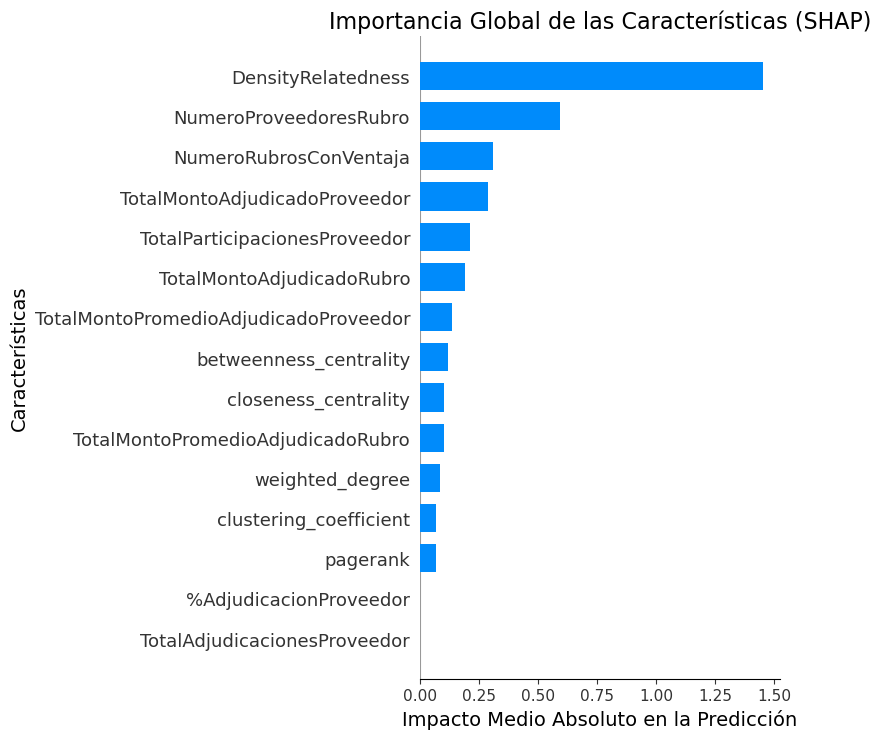

In [12]:
# Tamaño de la muestra
sample_size = 10000  # Ajusta según los recursos disponibles

# Muestrear datos del conjunto de prueba
X_test_sample = X_test.sample(n=sample_size, random_state=42)

# Crear un explicador SHAP para XGBoost
explainer = shap.Explainer(xgb_model, X_train_balanced)

# Calcular valores SHAP
shap_values = explainer(X_test_sample)

# Gráfico de resumen (tipo bar para importancia global)
plt.figure(figsize=(12, 6))  # Cambia tamaño de la figura
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title("Importancia Global de las Características (SHAP)", fontsize=16)
plt.xlabel("Impacto Medio Absoluto en la Predicción", fontsize=14)
plt.ylabel("Características", fontsize=14)
plt.tight_layout()
plt.savefig("shap_summary_bar.png")  # Guardar visualización como archivo
plt.show()

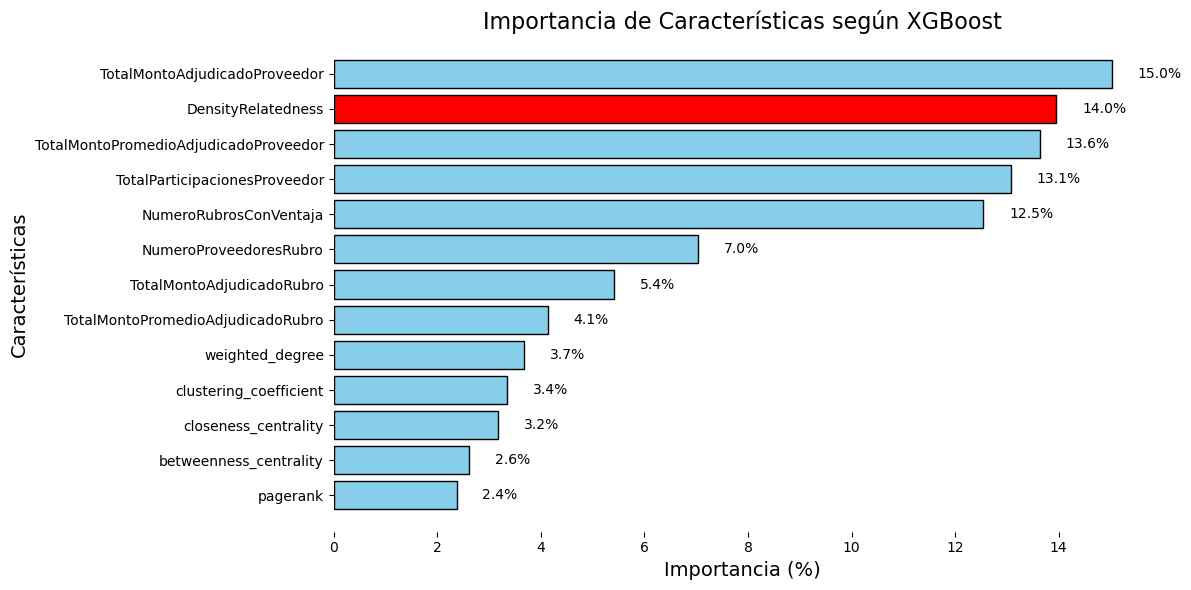

Importancia de Características según el Modelo XGBoost (en %):
                           Característica  Porcentaje
2           TotalMontoAdjudicadoProveedor   15.023722
0                      DensityRelatedness   13.951854
3   TotalMontoPromedioAdjudicadoProveedor   13.635565
1           TotalParticipacionesProveedor   13.073274
4                  NumeroRubrosConVentaja   12.546125
7                  NumeroProveedoresRubro    7.028642
5               TotalMontoAdjudicadoRubro    5.412054
6       TotalMontoPromedioAdjudicadoRubro    4.129327
8                         weighted_degree    3.672465
12                 clustering_coefficient    3.356176
10                   closeness_centrality    3.180460
9                  betweenness_centrality    2.618169
11                               pagerank    2.372167


In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtener la importancia de las características directamente del modelo
feature_importance = xgb_model.get_booster().get_score(importance_type='weight')

# Crear un DataFrame para organizar y visualizar
importance_df = pd.DataFrame({
    'Característica': feature_importance.keys(),
    'Importancia': feature_importance.values()
})

# Calcular el porcentaje de importancia
total_importance = sum(importance_df['Importancia'])
importance_df['Porcentaje'] = (importance_df['Importancia'] / total_importance) * 100

# Ordenar por importancia descendente
importance_df = importance_df.sort_values(by='Porcentaje', ascending=False)

# Resaltar la característica 'DensityRelatedness' con un color diferente
colors = [
    'red' if feature == 'DensityRelatedness' else 'skyblue'
    for feature in importance_df['Característica']
]

# Visualización de la importancia de características con etiquetas
plt.figure(figsize=(12, 6))
bars = plt.barh(
    importance_df['Característica'], 
    importance_df['Porcentaje'], 
    color=colors, 
    edgecolor='black'
)

# Agregar etiquetas sobre las barras
for bar, percentage in zip(bars, importance_df['Porcentaje']):
    plt.text(
        bar.get_width() + 0.5,  # Posición X (ligeramente a la derecha de la barra)
        bar.get_y() + bar.get_height() / 2,  # Posición Y (en el centro de la barra)
        f"{percentage:.1f}%",  # Formato de la etiqueta
        va='center', 
        fontsize=10
    )

# Personalizar el diseño del gráfico para eliminar el marco
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.title("Importancia de Características según XGBoost", fontsize=16)
plt.xlabel("Importancia (%)", fontsize=14)
plt.ylabel("Características", fontsize=14)
plt.gca().invert_yaxis()  # Invertir el eje Y para que las características más importantes aparezcan arriba
plt.tight_layout()
plt.savefig("xgboost_feature_importance_no_frame.png")  # Guardar la visualización como archivo
plt.show()

# Mostrar la tabla de importancia para referencia
print("Importancia de Características según el Modelo XGBoost (en %):")
print(importance_df[['Característica', 'Porcentaje']])

In [34]:
# Crear un sample aleatorio
sample_size = 10000
X_test_sample = X_test.sample(n=sample_size, random_state=42)

# Garantizar que el sample incluya los índices seleccionados
selected_cases = X_test.loc[list(indices.values())]  # Extraer los casos seleccionados
X_test_sample = pd.concat([X_test_sample, selected_cases]).drop_duplicates()

print(f"Tamaño del sample ajustado: {X_test_sample.shape}")

Tamaño del sample ajustado: (9849, 15)


In [36]:
# Verificar nuevamente si los índices seleccionados están en el sample
valid_indices = {case: idx for case, idx in indices.items() if idx in X_test_sample.index}

print(f"Índices presentes en el sample ajustado: {list(valid_indices.keys())}")
print(f"Índices ausentes en el sample ajustado: {set(indices.keys()) - set(valid_indices.keys())}")


Índices presentes en el sample ajustado: ['VP', 'VN', 'FP', 'FN']
Índices ausentes en el sample ajustado: set()


 97%|=================== | 9506/9849 [00:29<00:01]       

Generando gráfico para VP (índice: 29592056)...


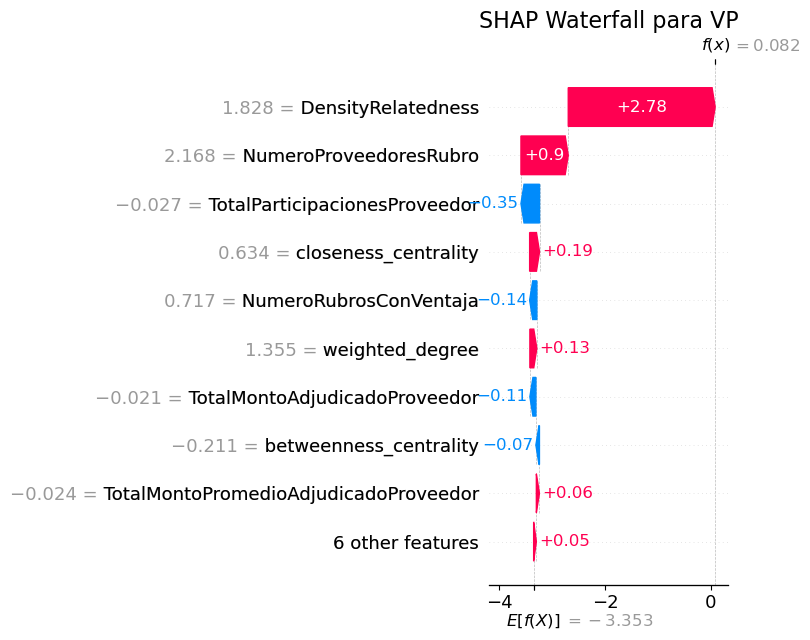

Presiona Enter para continuar al siguiente gráfico (VP)... 


Generando gráfico para VN (índice: 31341457)...


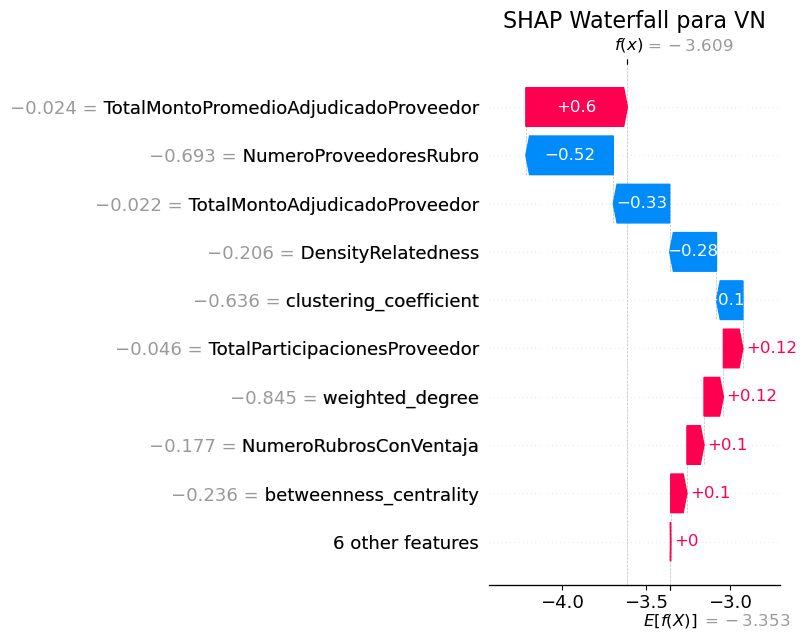

Presiona Enter para continuar al siguiente gráfico (VN)... 


Generando gráfico para FP (índice: 18166020)...


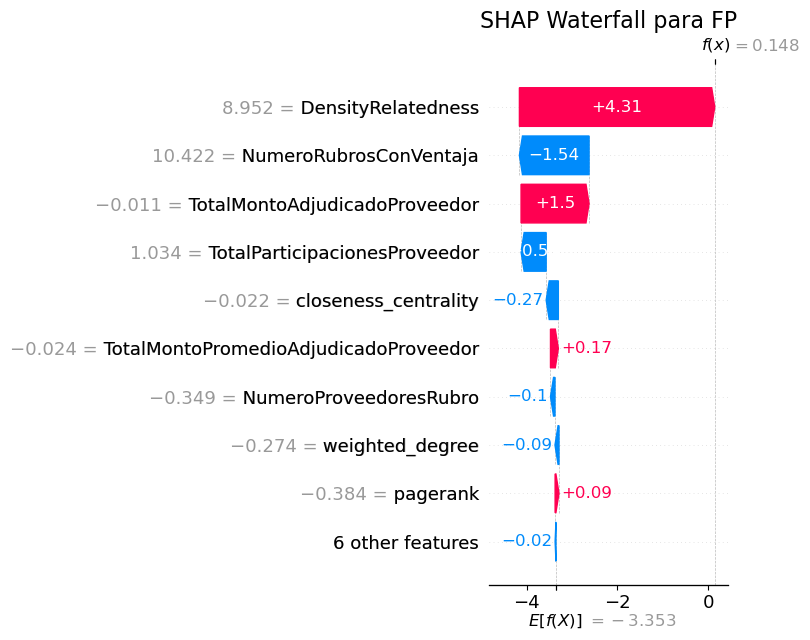

Presiona Enter para continuar al siguiente gráfico (FP)... 


Generando gráfico para FN (índice: 2135948)...


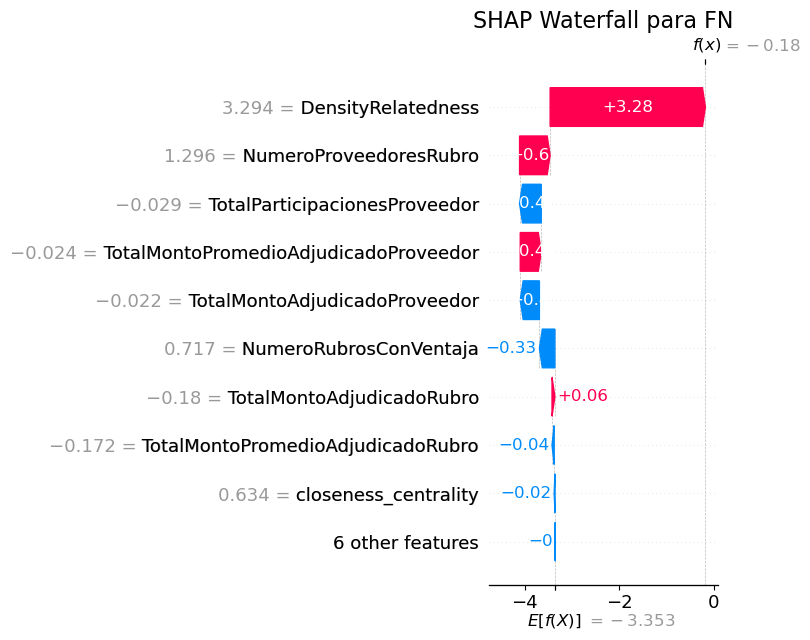

Presiona Enter para continuar al siguiente gráfico (FN)... 


In [40]:
import shap
import matplotlib.pyplot as plt

# Crear un explicador SHAP
shap_explainer = shap.Explainer(xgb_model, X_train_balanced)
shap_values_sample = shap_explainer(X_test_sample)

# Generar gráficos waterfall para cada índice presente en el sample
for case, index in valid_indices.items():
    # Extraer valores SHAP para el caso específico
    instance_shap_values = shap_values_sample[X_test_sample.index == index]
    
    # Graficar waterfall para el caso específico
    print(f"Generando gráfico para {case} (índice: {index})...")
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(instance_shap_values[0], show=False)
    plt.title(f"SHAP Waterfall para {case}", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"shap_waterfall_{case.lower()}.png")  # Guardar la figura
    plt.show()

    # Pausa para ver cada gráfico antes de pasar al siguiente
    input(f"Presiona Enter para continuar al siguiente gráfico ({case})...")